# Italian Financial Challenge - Starter Template

**Student Name:** [Your Name]

**Challenge:** [Choose: Bankruptcy Prediction / Financial Health Classification / Revenue Forecasting]

**Date:** [Date]

---

## Instructions

This template provides a suggested structure for your challenge solution. You can adapt it to your needs, but make sure to cover all required sections:

1. Problem Statement and Objectives
2. Data Loading and Exploration
3. Data Preprocessing
4. Feature Engineering
5. Model Development
6. Model Evaluation
7. Interpretation and Business Insights
8. Conclusions and Future Work

**Remember:**
- Document your thought process with markdown cells
- Comment your code clearly
- Create visualizations to support your insights
- Interpret results in business terms
- Check the evaluation rubric to ensure you meet all criteria

## 1. Problem Statement and Objectives

**Challenge:** [Describe which challenge you chose and why]

**Objective:** [State the prediction goal clearly]

**Success Criteria:** [Define what "good" performance looks like for your chosen challenge]

**Approach:** [Briefly outline your planned approach]

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

# Create images folder for saved plots
IMAGES_DIR = Path('../images')
IMAGES_DIR.mkdir(exist_ok=True)

def save_fig(name, dpi=150):
    path = IMAGES_DIR / f"{name}.png"
    plt.savefig(path, dpi=dpi, bbox_inches="tight")



Libraries imported successfully!


## 2. Data Loading and Exploration (Refactored EDA: Lean, Defensible, Leakage-Safe)

This section prioritizes a minimal, high-signal set of plots (8–10) with scale-aware visuals.


### 1. Dataset Overview


In [2]:
# Load training data
train_df = pd.read_csv('../data/processed/train_data.csv')

# Keep full dataset for modeling (EDA uses train-only split)
full_df = train_df.copy()


# EDA split (train-only to avoid leakage)
train_years_eda = [2018, 2019]
val_year_eda = 2020
if 'fiscal_year' in full_df.columns:
    train_df = full_df[full_df['fiscal_year'].isin(train_years_eda)].copy()


# Explicit target definition for Challenge 3
target_col = 'revenue_change'
target_definition = "Percent change in production_value vs prior year"
target_units = "percentage (%)"

# Columns that are coded as numeric but represent categories
categorical_like_cols = ['ateco_sector'] if 'ateco_sector' in train_df.columns else []

# Basic dataset info
print(f"Full dataset shape (rows, cols): {full_df.shape}")
print(f"EDA dataset (train-only) rows: {train_df.shape[0]}")
print(f"Unique companies (EDA): {train_df['company_id'].nunique()}")
print(f"Fiscal year range (EDA): {train_df['fiscal_year'].min()} - {train_df['fiscal_year'].max()}")
print(f"Target: {target_col} ({target_units}) - {target_definition}")

# Feature type breakdown
id_cols = ['company_id']
time_cols = ['fiscal_year']
leakage_targets = ['bankruptcy_next_year', 'financial_health_class']

numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

numeric_features = [
    c for c in numeric_cols
    if c not in id_cols + time_cols + [target_col] + leakage_targets + categorical_like_cols
]

categorical_features = [c for c in categorical_cols if c not in id_cols + leakage_targets]
for c in categorical_like_cols:
    if c not in categorical_features:
        categorical_features.append(c)

print("\nFeature type counts:")
print(f"Identifiers: {id_cols}")
print(f"Time columns: {time_cols}")
print(f"Target column: {target_col}")
print(f"Other target cols to exclude: {leakage_targets}")
print(f"Numeric feature cols: {len(numeric_features)}")
print(f"Categorical feature cols: {len(categorical_features)}")
print(f"Total usable feature cols: {len(numeric_features) + len(categorical_features)}")


Full dataset shape (rows, cols): (11828, 30)
EDA dataset (train-only) rows: 5940
Unique companies (EDA): 2999
Fiscal year range (EDA): 2018 - 2019
Target: revenue_change (percentage (%)) - Percent change in production_value vs prior year

Feature type counts:
Identifiers: ['company_id']
Time columns: ['fiscal_year']
Target column: revenue_change
Other target cols to exclude: ['bankruptcy_next_year', 'financial_health_class']
Numeric feature cols: 21
Categorical feature cols: 4
Total usable feature cols: 25


**What this shows:** dataset scale, feature types, and explicit exclusion of leakage targets.  
**Why it matters for modeling:** establishes which columns are safe and eligible for feature engineering.


**Units and domain assumptions:**
- Monetary columns are annual values in euros.
- Ratio columns are unitless and may be negative when equity/profit is negative.
- `revenue_change` is a percent (%) derived from year-over-year production value.


### 2. Helper Functions (Reusable, Leakage-Safe)


In [3]:
# Helper functions (EDA only)

def get_numeric_features(df, exclude_cols, categorical_like_cols):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return [c for c in numeric_cols if c not in exclude_cols + categorical_like_cols]


def top_skewed_features(df, numeric_features, k=6):
    skew_vals = df[numeric_features].skew(numeric_only=True).abs().sort_values(ascending=False)
    return skew_vals.head(k).index.tolist()


def clip_bounds(series, lower=0.01, upper=0.99):
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return lo, hi


def top_categories_with_other(df, col, top_n=10):
    vc = df[col].value_counts(dropna=False)
    top = vc.head(top_n).index
    return df[col].where(df[col].isin(top), other='Other')


**What this shows:** standardized helpers for clean, repeatable EDA.  
**Why it matters for modeling:** ensures consistent feature selection and category handling without leakage.


In [4]:
train_df.head(50)

,company_id,fiscal_year,province,region,ateco_sector,legal_form,years_in_business,total_fixed_assets,current_assets,total_assets,shareholders_equity,total_debt,short_term_debt,long_term_debt,production_value,production_costs,operating_income,financial_income,financial_expenses,net_profit_loss,roe,roi,leverage,current_ratio,quick_ratio,debt_to_assets,profit_margin,bankruptcy_next_year,financial_health_class,revenue_change
0,COMP_00000,2018,NaN,Campania,47,SRL,32,2.422343e+08,9.504819e+08,1.192716e+09,3.728702e+08,8.198459e+08,5.601842e+08,2.596617e+08,1.846636e+09,1.611363e+09,2.352729e+08,4.886785e+06,2.006807e+07,2.152049e+08,0.5772,0.1973,2.1987,1.6967,1.0180,0.6874,0.1165,0,B,NaN
1,COMP_00000,2019,NaN,Campania,47,SRL,33,3.983639e+07,1.411226e+08,1.809589e+08,5.700701e+07,1.239519e+08,7.135345e+07,5.259848e+07,4.289159e+08,3.896038e+08,3.931218e+07,5.824606e+04,2.537224e+06,3.677495e+07,0.6451,0.2172,2.1743,1.9778,1.1867,0.6850,0.0857,0,B,-76.77
4,COMP_00001,2018,CA,Sardegna,62,SRL,8,8.348035e+07,1.325697e+08,2.160500e+08,6.566937e+07,1.503807e+08,7.582482e+07,7.455584e+07,4.113380e+08,3.912414e+08,2.009667e+07,6.405389e+05,5.860639e+06,1.423603e+07,0.2168,0.0930,2.2900,1.7484,1.0490,0.6960,0.0346,0,B,NaN
5,COMP_00001,2019,CA,Sardegna,62,SRL,9,3.073529e+08,6.198199e+08,9.271728e+08,1.971135e+08,7.300593e+08,3.330192e+08,3.970401e+08,1.595547e+09,1.531041e+09,6.450566e+07,8.664984e+05,1.930480e+07,4.520087e+07,0.2293,0.0696,3.7038,1.8612,1.1167,0.7874,0.0283,0,C,287.89
8,COMP_00002,2018,BA,Puglia,41,SAS,35,3.906155e+07,2.581125e+07,6.487280e+07,3.041047e+07,3.446234e+07,2.092435e+07,1.353798e+07,4.927393e+07,4.407296e+07,5.200967e+06,9.342130e+03,9.787175e+05,4.222250e+06,0.1388,0.0802,1.1332,1.2336,0.7401,0.5312,0.0857,0,B,NaN
9,COMP_00002,2019,BA,Puglia,41,SAS,36,4.972305e+08,4.408289e+08,9.380594e+08,3.659860e+08,5.720734e+08,3.497927e+08,2.222807e+08,9.684350e+08,9.060527e+08,6.238225e+07,3.221395e+06,1.248068e+07,4.990157e+07,0.1363,0.0665,1.5631,1.2603,0.7562,0.6098,0.0515,0,B,1865.41
12,COMP_00003,2019,BO,Emilia-Romagna,47,SRL,0,1.026930e+08,2.132490e+08,3.159420e+08,1.118909e+08,2.040511e+08,1.160172e+08,8.803389e+07,8.162210e+08,7.524226e+08,6.379844e+07,4.678382e+05,1.001629e+07,5.378215e+07,0.4807,0.2019,1.8237,1.8381,1.1028,0.6458,0.0659,0,B,NaN
15,COMP_00004,2018,MI,Lombardia,46,SRL,52,9.141818e+06,5.109884e+07,6.024066e+07,1.509134e+07,4.514932e+07,1.938260e+07,2.576672e+07,1.056556e+08,9.491430e+07,1.074128e+07,2.694908e+05,1.180541e+06,9.560741e+06,0.6335,0.1783,2.9917,2.6363,1.5818,0.7495,0.0905,0,C,NaN
16,COMP_00004,2019,MI,Lombardia,46,SRL,53,9.954543e+07,2.955461e+08,3.950915e+08,1.195691e+08,2.755224e+08,1.768476e+08,9.867480e+07,1.470167e+09,1.306517e+09,1.636495e+08,1.498728e+06,9.092518e+06,1.545570e+08,1.2926,0.4142,2.3043,1.6712,1.0027,0.6974,0.1051,0,B,1291.47
19,COMP_00005,2018,MI,Lombardia,62,SNC,49,5.795863e+07,1.050352e+08,1.629938e+08,4.915084e+07,1.138430e+08,5.776893e+07,5.607402e+07,1.418222e+08,1.331785e+08,8.643720e+06,3.985340e+05,2.915712e+06,5.728008e+06,0.1165,0.0530,2.3162,1.8182,1.0909,0.6984,0.0404,0,B,NaN


### 3. Target Distribution (Skew-Aware)


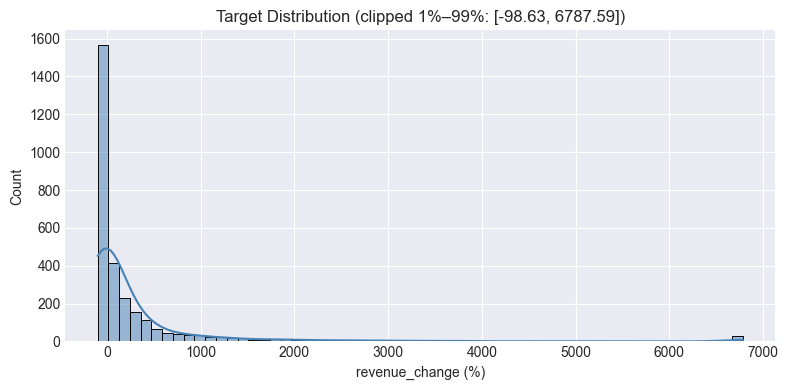

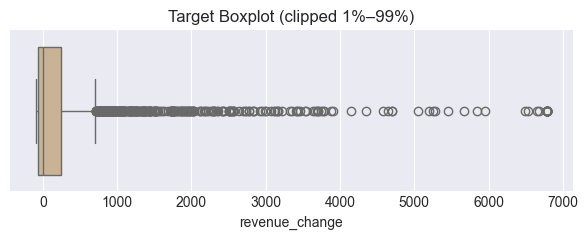

In [5]:
# Target histogram with clipped view (visualization only)
target_series = train_df[target_col].dropna()
lo, hi = clip_bounds(target_series, 0.01, 0.99)

plt.figure(figsize=(8, 4))
sns.histplot(target_series.clip(lo, hi), bins=60, kde=True, color='steelblue')
plt.title(f"Target Distribution (clipped 1%–99%: [{lo:.2f}, {hi:.2f}])")
plt.xlabel(f"{target_col} (%)")
plt.tight_layout()
save_fig('target_hist_clipped')
plt.show()

plt.figure(figsize=(6, 2.5))
sns.boxplot(x=target_series.clip(lo, hi), color='tan')
plt.title('Target Boxplot (clipped 1%–99%)')
plt.tight_layout()
save_fig('target_boxplot_clipped')
plt.show()


**What this shows:** the central mass of the target with heavy tails still present (visual clipping only).
**Why it matters for modeling:** tail risk and heteroskedasticity imply robust losses (MAE/Huber), and possibly log-transforming the target for stability.


### 4. Missingness Overview


Missing Values (non-zero):


,Missing Count,Percentage
revenue_change,2999,50.488215
province,460,7.744108
leverage,23,0.387205
roe,23,0.387205


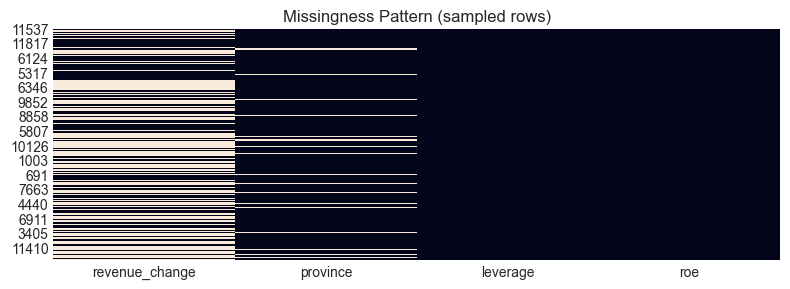

In [6]:
# Missingness table
missing_values = train_df.isnull().sum()
missing_pct = (missing_values / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)

print("Missing Values (non-zero):")
display(missing_df[missing_df['Missing Count'] > 0])

# Missingness pattern heatmap (sampled rows)
missing_cols = missing_df[missing_df['Missing Count'] > 0].index.tolist()
if missing_cols:
    sample = train_df[missing_cols].isna().sample(min(300, len(train_df)), random_state=RANDOM_STATE)
    plt.figure(figsize=(8, 3))
    sns.heatmap(sample, cbar=False)
    plt.title('Missingness Pattern (sampled rows)')
    plt.tight_layout()
    save_fig('missingness_pattern')
    plt.show()


**What this shows:** which columns are incomplete and whether missingness is structured.  
**Why it matters for modeling:** supports targeted imputation and optional missingness indicators.


### 5. Outlier Behavior (Top Skewed Monetary Features)


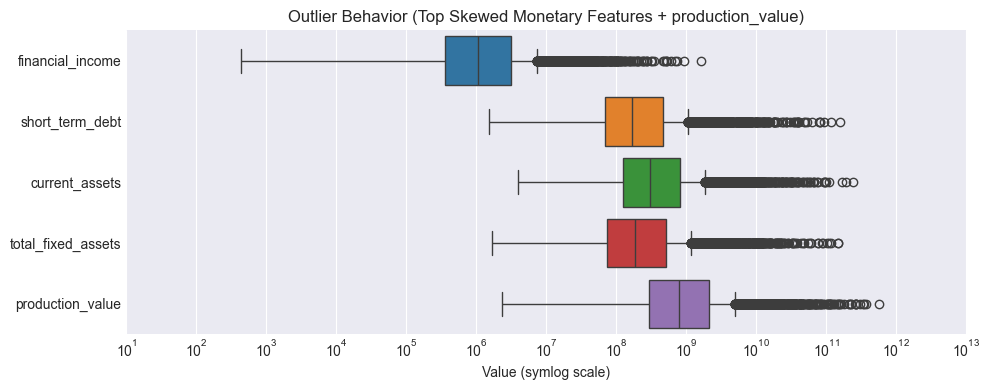

In [7]:
# Outlier behavior via top skewed numeric features (log-scale view for readability)
exclude_cols = ['company_id', 'fiscal_year', target_col, 'bankruptcy_next_year']
num_features = get_numeric_features(train_df, exclude_cols, categorical_like_cols)

# Heuristic: focus on monetary features (exclude ratios)
monetary_like = [c for c in num_features if any(x in c for x in ['assets', 'debt', 'income', 'value', 'costs', 'profit'])]
if len(monetary_like) >= 4:
    top_outlier_cols = top_skewed_features(train_df, monetary_like, k=4)
else:
    top_outlier_cols = top_skewed_features(train_df, num_features, k=4)

# Always include production_value if present
if 'production_value' in num_features and 'production_value' not in top_outlier_cols:
    top_outlier_cols = top_outlier_cols + ['production_value']

plt.figure(figsize=(10, 4))
sns.boxplot(data=train_df[top_outlier_cols], orient='h')
plt.xscale('symlog', linthresh=1.0)

# Clip x-axis to positive range (no space below 0)
lo, hi = clip_bounds(train_df[top_outlier_cols].stack().dropna(), 0.01, 0.99)
plt.xlim(1e1, 1e13)
plt.title('Outlier Behavior (Top Skewed Monetary Features + production_value)')
plt.xlabel('Value (symlog scale)')
plt.tight_layout()
save_fig('outlier_boxplots_top4_symlog')
plt.show()


**What this shows:** tail behavior in core monetary variables without extreme compression.  
**Why it matters for modeling:** motivates robust scaling or tree models that handle heavy tails.


### 6. Representative Numeric Distributions


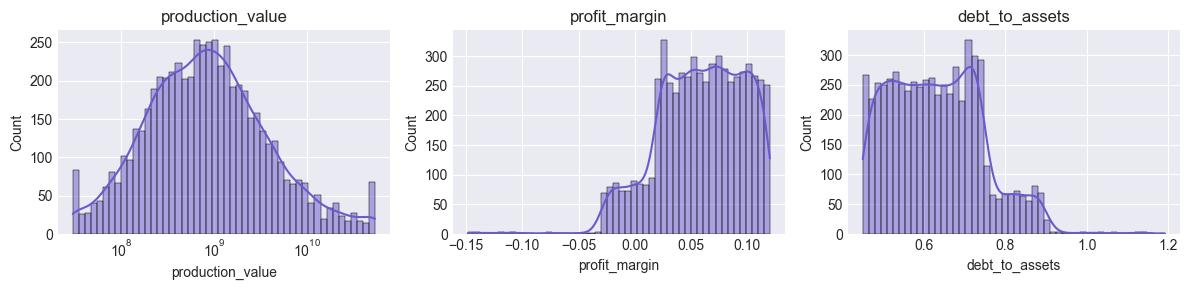

In [8]:
# Representative features: scale (production_value), profitability (profit_margin), leverage (debt_to_assets)
rep_features = [
    c for c in ['production_value', 'profit_margin', 'debt_to_assets']
    if c in train_df.columns
]

fig, axes = plt.subplots(1, len(rep_features), figsize=(4 * len(rep_features), 3))
if len(rep_features) == 1:
    axes = [axes]

for ax, col in zip(axes, rep_features):
    data = train_df[col].dropna()
    if col in ['production_value']:
        data = data.clip(*clip_bounds(data, 0.01, 0.99))
        ax.set_xscale('symlog', linthresh=1.0)
    sns.histplot(data, bins=50, kde=True, ax=ax, color='slateblue')
    ax.set_title(col)

plt.tight_layout()
save_fig('representative_numeric_distributions')
plt.show()


**What this shows:** typical shapes for scale, profitability, and leverage features.  
**Why it matters for modeling:** indicates which variables need scaling or transformation for linear models.


### 7. Multicollinearity Structure


Dropped (scale/total group): ['total_assets', 'shareholders_equity', 'total_debt', 'short_term_debt', 'long_term_debt', 'production_value', 'production_costs', 'financial_expenses', 'net_profit_loss']
Kept (scale/total group): ['total_fixed_assets', 'current_assets', 'operating_income', 'financial_income']
Dropped (ratio group): ['quick_ratio']
Kept (ratio group): ['roe', 'roi', 'profit_margin', 'leverage', 'debt_to_assets', 'current_ratio']


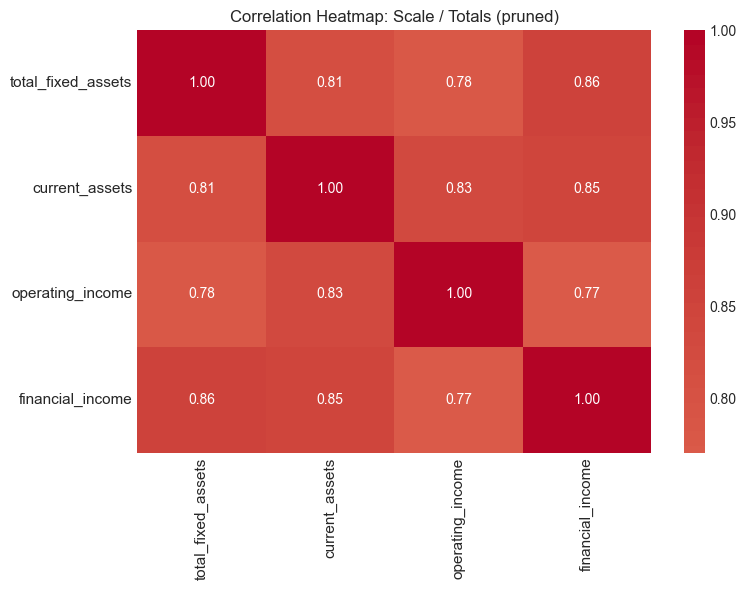

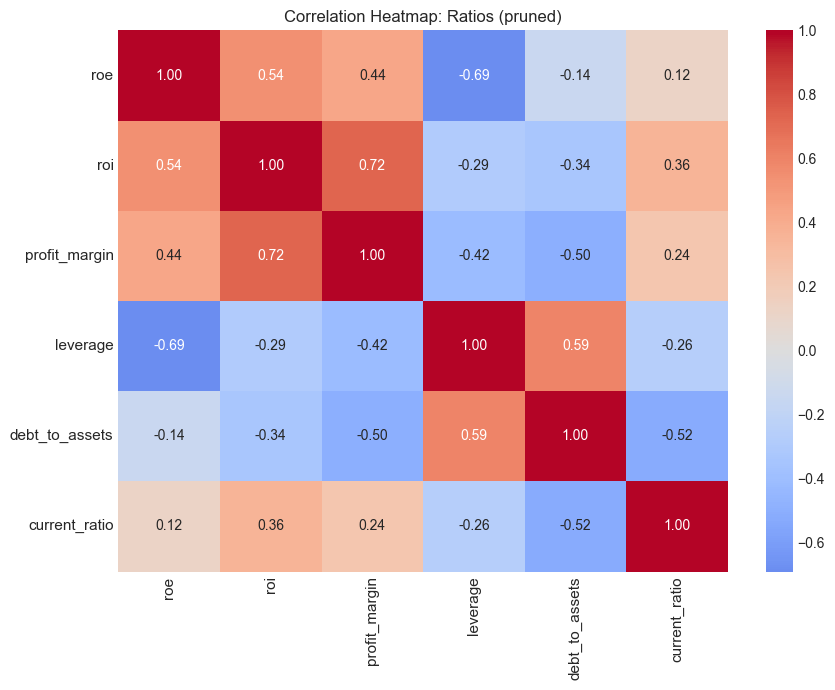

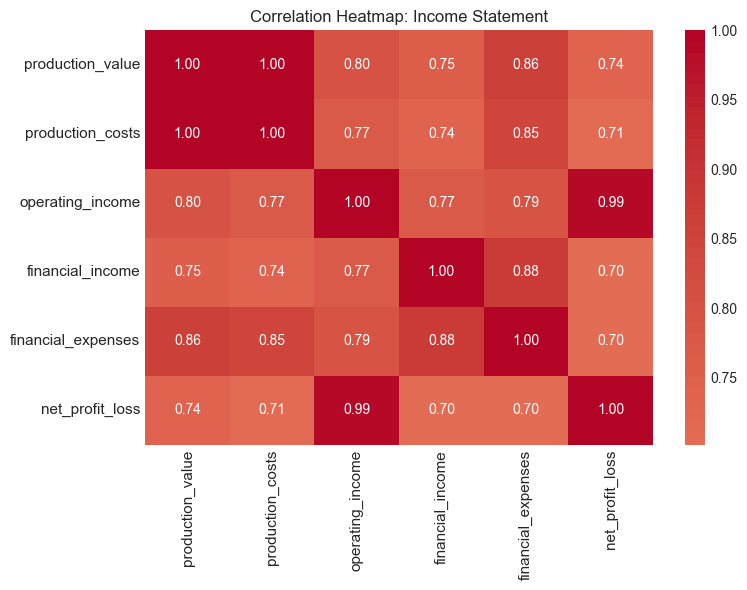

In [9]:
# Correlation heatmaps split into totals vs ratios + drop highly correlated (>|0.90|)
exclude_cols = ['company_id', 'fiscal_year', target_col, 'bankruptcy_next_year']
num_features = get_numeric_features(train_df, exclude_cols, categorical_like_cols)

# Define ratio vs totals groups (adjust if needed)
ratio_features = [
    c for c in ['roe', 'roi', 'profit_margin', 'leverage', 'debt_to_assets', 'current_ratio', 'quick_ratio']
    if c in num_features
]

# Income statement group (core statement line items)
income_statement_candidates = [
    'production_value', 'production_costs', 'operating_income',
    'financial_income', 'financial_expenses', 'net_profit_loss'
]
income_statement_features = [c for c in income_statement_candidates if c in num_features]

scale_features = [c for c in num_features if c not in ratio_features]

# Drop years_in_business explicitly from scale heatmap
scale_features = [c for c in scale_features if c != 'years_in_business']

# Drop highly correlated features within each group (greedy, |corr| > 0.90)

def drop_high_corr(df, cols, threshold=0.90):
    corr = df[cols].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop_cols = [col for col in upper.columns if any(upper[col] > threshold)]
    keep_cols = [c for c in cols if c not in drop_cols]
    return keep_cols, drop_cols, corr

scale_keep, scale_drop, scale_corr = drop_high_corr(train_df, scale_features, threshold=0.90)
ratio_keep, ratio_drop, ratio_corr = drop_high_corr(train_df, ratio_features, threshold=0.90)

print("Dropped (scale/total group):", scale_drop)
print("Kept (scale/total group):", scale_keep)
print("Dropped (ratio group):", ratio_drop)
print("Kept (ratio group):", ratio_keep)

# Heatmap A: Scale/Totals
plt.figure(figsize=(8, 6))
sns.heatmap(train_df[scale_keep].corr(), cmap='coolwarm', center=0, annot=True, fmt='.2f')
plt.title('Correlation Heatmap: Scale / Totals (pruned)')
plt.xticks(fontsize=11, rotation=90)
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
save_fig('correlation_heatmap_scale_totals')
plt.show()

# Heatmap B: Ratios
if len(ratio_keep) > 0:
    plt.figure(figsize=(9, 7))
    sns.heatmap(train_df[ratio_keep].corr(), cmap='coolwarm', center=0, annot=True, fmt='.2f')
    plt.title('Correlation Heatmap: Ratios (pruned)')
    plt.xticks(fontsize=11, rotation=90)
    plt.yticks(fontsize=11, rotation=0)
    plt.tight_layout()
    save_fig('correlation_heatmap_ratios')
    plt.show()

# Heatmap C: Income Statement
if len(income_statement_features) > 1:
    plt.figure(figsize=(8, 6))
    sns.heatmap(train_df[income_statement_features].corr(), cmap='coolwarm', center=0, annot=True, fmt='.2f')
    plt.title('Correlation Heatmap: Income Statement')
    plt.xticks(fontsize=11, rotation=90)
    plt.yticks(fontsize=11, rotation=0)
    plt.tight_layout()
    save_fig('correlation_heatmap_income_statement')
    plt.show()


**What this shows:** strong linear dependencies among financial totals and ratios.  
**Why it matters for modeling:** suggests regularization (Ridge/ElasticNet) or tree-based models.


### 8. Feature–Target Relationships (Top 2, Interpretable)


Top 10 numeric features by absolute Spearman correlation with target:


,pearson,spearman
production_value,0.321149,0.548007
production_costs,0.314071,0.547065
total_assets,0.317105,0.539869
total_debt,0.301143,0.536473
current_assets,0.318406,0.536009
short_term_debt,0.303153,0.534950
long_term_debt,0.288242,0.527544
financial_expenses,0.299711,0.526497
shareholders_equity,0.330327,0.515829
total_fixed_assets,0.275325,0.515406


Bottom 10 numeric features by absolute Spearman correlation with target:


,pearson,spearman
financial_income,0.284583,0.452087
net_profit_loss,0.350031,0.434489
roe,0.002902,0.076266
roi,0.031145,0.074139
quick_ratio,0.025268,-0.021271
current_ratio,0.025268,-0.021271
profit_margin,0.033993,0.017911
years_in_business,0.009685,-0.014359
debt_to_assets,-0.032051,-0.004499
leverage,-0.014446,-0.002920


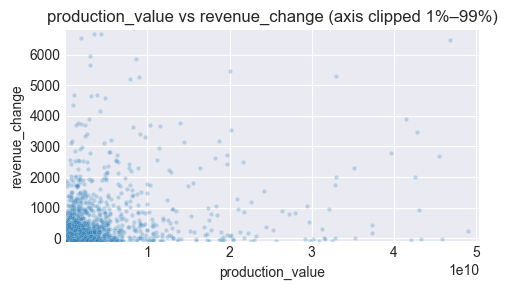

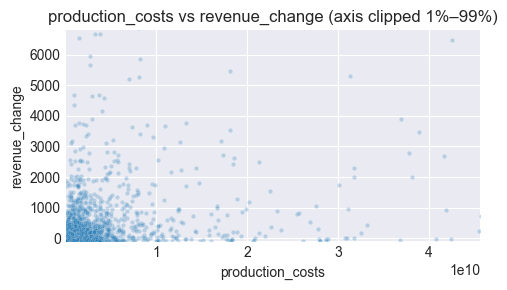

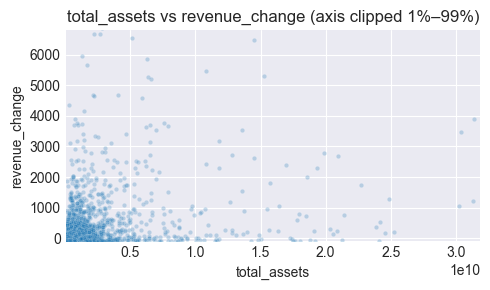

In [10]:
# Correlation of numeric features with target (Pearson and Spearman)
analysis_df = train_df.dropna(subset=[target_col])

numeric_cols = analysis_df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['company_id', 'fiscal_year', target_col, 'bankruptcy_next_year'] + categorical_like_cols
numeric_features = [c for c in numeric_cols if c not in exclude_cols]

pearson_corr = analysis_df[numeric_features].corrwith(analysis_df[target_col])
spearman_corr = analysis_df[numeric_features].corrwith(analysis_df[target_col], method='spearman')

corr_df = pd.DataFrame({
    'pearson': pearson_corr,
    'spearman': spearman_corr
}).sort_values('spearman', key=lambda s: s.abs(), ascending=False)

print("Top 10 numeric features by absolute Spearman correlation with target:")
display(corr_df.head(10))

print("Bottom 10 numeric features by absolute Spearman correlation with target:")
display(corr_df.tail(10))

# Scatter plots for the top 3 features with axis-only clipping (1%–99%)
for col in corr_df.head(3).index:
    x = analysis_df[col].values
    y = analysis_df[target_col].values

    x_clip = clip_bounds(pd.Series(x), 0.01, 0.99)
    y_clip = clip_bounds(pd.Series(y), 0.01, 0.99)

    plt.figure(figsize=(5, 3))
    sns.scatterplot(data=analysis_df, x=col, y=target_col, alpha=0.25, s=10)
    plt.title(f'{col} vs {target_col} (axis clipped 1%–99%)')
    plt.xlim(x_clip)
    plt.ylim(y_clip)
    plt.tight_layout()
    save_fig(f'feature_target_scatter_{col}')
    plt.show()

# Categorical relationships with target (violin plots for top categories) with y-axis clipping
cat_cols = analysis_df.select_dtypes(include=['object']).columns.tolist()
cat_features = [c for c in cat_cols if c not in ['company_id', 'financial_health_class']]
for c in categorical_like_cols:
    if c not in cat_features:
        cat_features.append(c)



**What this shows:** density concentrates in narrow bands with non‑linear spread and weak conditional shifts.
**Why it matters for modeling:** simple linear fits will underperform; consider log inputs, interaction terms, or tree/boosted models.


### 9. Categorical Signal (Top-N + Other)


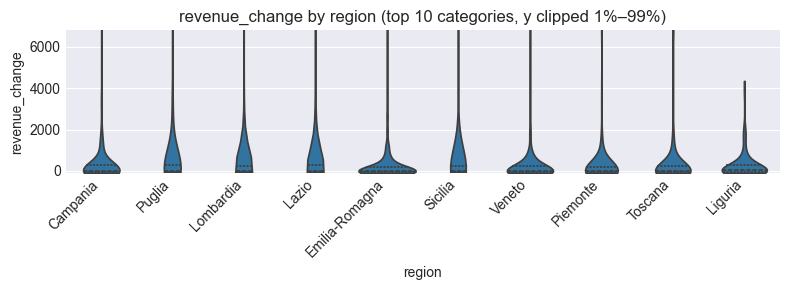

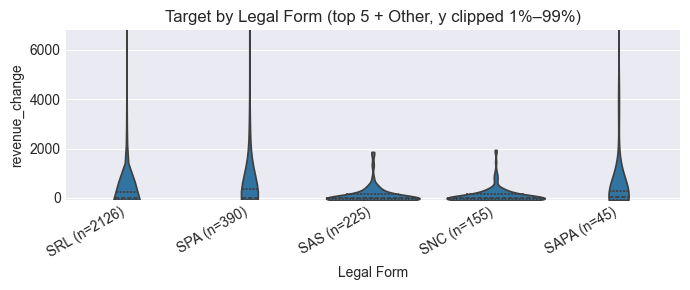

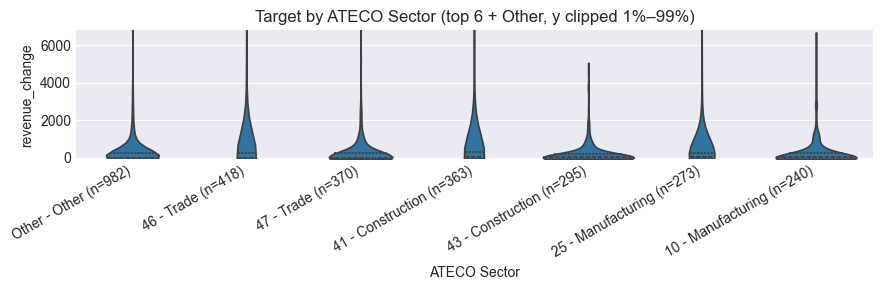

In [11]:
# Compute target clip bounds for consistent y-axis scaling
y_lo, y_hi = clip_bounds(analysis_df[target_col], 0.01, 0.99)

for col in [c for c in [ 'region'] if c in cat_features]:
    top_cats = analysis_df[col].value_counts().head(10).index
    plot_df = analysis_df[analysis_df[col].isin(top_cats)]
    plt.figure(figsize=(8, 3))
    sns.violinplot(data=plot_df, x=col, y=target_col, inner='quartile', cut=0)
    plt.title(f'{target_col} by {col} (top 10 categories, y clipped 1%–99%)')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(y_lo, y_hi)
    plt.tight_layout()
    save_fig(f'target_by_{col}')
    plt.show()
# Analysis: diagnostics only; do not engineer features here to avoid leakage.

# Target by legal_form (top-N + Other) with y-axis clipping and violin plots
if 'legal_form' in train_df.columns:
    plot_df = train_df[[target_col, 'legal_form']].dropna()
    plot_df['legal_form_grouped'] = top_categories_with_other(plot_df, 'legal_form', top_n=5)

    counts = plot_df['legal_form_grouped'].value_counts()
    order = counts.index.tolist()
    labels = [f"{cat} (n={counts[cat]})" for cat in order]

    y_lo, y_hi = clip_bounds(plot_df[target_col], 0.01, 0.99)

    plt.figure(figsize=(7, 3))
    sns.violinplot(data=plot_df, x='legal_form_grouped', y=target_col, order=order, inner='quartile', cut=0)
    plt.title('Target by Legal Form (top 5 + Other, y clipped 1%–99%)')
    plt.xlabel('Legal Form')
    plt.ylabel(target_col)
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=30, ha='right')
    plt.ylim(y_lo, y_hi)
    plt.tight_layout()
    save_fig('target_by_legal_form')
    plt.show()

# Target by ateco_sector (top-N + Other) with y-axis clipping and violin plots
if 'ateco_sector' in train_df.columns:
    plot_df = train_df[[target_col, 'ateco_sector']].dropna()
    plot_df['ateco_sector_grouped'] = top_categories_with_other(plot_df, 'ateco_sector', top_n=6)

    # ATECO 2-digit sector name mapping (compact, for labels)
    def ateco_name(code):
        try:
            c = int(str(code))
        except Exception:
            return 'Other'
        if 1 <= c <= 3:
            return 'Agriculture'
        if 5 <= c <= 9:
            return 'Mining'
        if 10 <= c <= 33:
            return 'Manufacturing'
        if c == 35:
            return 'Utilities'
        if 36 <= c <= 39:
            return 'Water/Waste'
        if 41 <= c <= 43:
            return 'Construction'
        if 45 <= c <= 47:
            return 'Trade'
        if 49 <= c <= 53:
            return 'Transport'
        if 55 <= c <= 56:
            return 'Accommodation/Food'
        if 58 <= c <= 63:
            return 'Info/Comm'
        if 64 <= c <= 66:
            return 'Finance/Insurance'
        if c == 68:
            return 'Real Estate'
        if 69 <= c <= 75:
            return 'Prof/Tech'
        if 77 <= c <= 82:
            return 'Admin/Support'
        if c == 84:
            return 'Public Admin'
        if c == 85:
            return 'Education'
        if 86 <= c <= 88:
            return 'Health/Social'
        if 90 <= c <= 93:
            return 'Arts/Rec'
        if 94 <= c <= 96:
            return 'Other Services'
        return 'Other'

    counts = plot_df['ateco_sector_grouped'].value_counts()
    order = counts.index.tolist()
    labels = [f"{code} - {ateco_name(code)} (n={counts[code]})" for code in order]

    y_lo, y_hi = clip_bounds(plot_df[target_col], 0.01, 0.99)

    plt.figure(figsize=(9, 3))
    sns.violinplot(data=plot_df, x='ateco_sector_grouped', y=target_col, order=order, inner='quartile', cut=0)
    plt.title('Target by ATECO Sector (top 6 + Other, y clipped 1%–99%)')
    plt.xlabel('ATECO Sector')
    plt.ylabel(target_col)
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=30, ha='right')
    plt.ylim(y_lo, y_hi)
    plt.tight_layout()
    save_fig('target_by_ateco_sector')
    plt.show()


**What this shows:** category medians differ, but IQR overlap is substantial in several groups.
**Why it matters for modeling:** categories carry signal but require robust encoding; tree models may capture cross‑effects better than linear baselines.


### 10. Leakage Audit (Mandatory)


In [12]:
# Identify suspicious columns that may contain future or post-event info
suspicious_patterns = ['next', 'future', 'after', 't+1', 'post']
flagged_cols = [
    c for c in train_df.columns
    if any(p in c.lower() for p in suspicious_patterns)
]

# Explicit known leakage targets
explicit_leakage = ['bankruptcy_next_year', 'financial_health_class']
flagged = sorted(set(flagged_cols + [c for c in explicit_leakage if c in train_df.columns]))

print("Flagged potential leakage columns:")
print(flagged)

print("\nLeakage prevention steps:")
print("- Exclude flagged columns from feature lists.")
print("- Use temporal splits by fiscal_year to avoid future information.")
print("- Do not engineer features using target values.")
print("- Use transformations only for visualization; no target-conditioned filtering.")


Flagged potential leakage columns:
['bankruptcy_next_year', 'financial_health_class']

Leakage prevention steps:
- Exclude flagged columns from feature lists.
- Use temporal splits by fiscal_year to avoid future information.
- Do not engineer features using target values.
- Use transformations only for visualization; no target-conditioned filtering.


**What this shows:** explicit audit of risky columns and safeguards.  
**Why it matters for modeling:** ensures evaluation integrity and prevents leakage-driven optimism.


### Key EDA Conclusions (Lean Summary)


- Target is heavy‑tailed and skewed; robust losses or transforms are likely necessary.
- Missingness is limited to a few columns, supporting focused imputation.
- Monetary features show extreme outliers; robust scaling or tree models are preferred.
- Strong multicollinearity exists among balance sheet totals; regularization is advisable.
- Legal form and sector show categorical signal worth encoding.
- Leakage risk is controlled by explicit exclusions and temporal splits.


## 3. Data Preprocessing

Handle missing values, outliers, and prepare data for modeling.

### Leakage-Safe Cleaning Pipeline (Challenge 3: revenue_change_next_year)

This pipeline follows a strict **no-leakage** discipline:
- **Row-wise cleaning** (types, identities, negatives, ratio validity) happens before splitting.
- **Statistical transforms** (imputation, winsorization, outlier thresholds, scaling) are **fit on TRAIN only** and applied to val/test.
- **Feature engineering** uses only current/past data within each company.
- **Target** is defined as **next-year revenue change** to avoid same-year leakage.


In [13]:
# --- Configuration ---
TARGET_COL = 'revenue_change_next_year'  # target = next year's revenue change (percent points)
EPS = 1e-9
NEG_CLIP_TOL = 1e-6  # treat tiny negatives as rounding
REV_CHANGE_CAP_LO = -95  # cap extreme YoY revenue change (lower, percent points)
REV_CHANGE_CAP_HI = 300   # cap extreme YoY revenue change (upper, percent points)
NEAR_ZERO_THR = 5  # threshold for near-zero targets (percent points)
JUMP_ABS_THR = 300  # abs jump threshold for lagged growth
JUMP_POS_THR = 300  # positive jump threshold
JUMP_NEG_THR = -60  # negative jump threshold
BASE_SMALL_Q = 0.20  # quantile for small-base flag (train-only)

RAW_ITEMS = [
    'total_fixed_assets', 'current_assets', 'total_assets',
    'shareholders_equity', 'total_debt', 'short_term_debt', 'long_term_debt',
    'production_value', 'production_costs', 'operating_income',
    'financial_income', 'financial_expenses', 'net_profit_loss'
]

RATIO_COLS = [
    'roe', 'roi', 'leverage', 'current_ratio', 'quick_ratio',
    'debt_to_assets', 'profit_margin'
]

NONNEG_COLS = [
    'total_fixed_assets', 'current_assets', 'total_assets',
    'total_debt', 'short_term_debt', 'long_term_debt',
    'production_value', 'production_costs',
    'financial_income', 'financial_expenses'
]

ID_COLS = ['company_id', 'fiscal_year']
LEAKAGE_COLS = ['bankruptcy_next_year', 'financial_health_class']

VALID_LEGAL_FORMS = {'SRL', 'SPA', 'SAPA', 'SAS', 'SNC'}

def std_str(s):
    return (
        s.astype('string')
         .str.strip()
         .str.upper()
         .replace({'': pd.NA, 'NAN': pd.NA, 'NONE': pd.NA})
    )

def standardize_legal_form(series):
    if series is None:
        return series, None
    s = std_str(series)
    repl = {
        'S.R.L.': 'SRL', 'S R L': 'SRL', 'SRL': 'SRL',
        'S.P.A.': 'SPA', 'S P A': 'SPA', 'SPA': 'SPA',
        'S.A.P.A.': 'SAPA', 'S A P A': 'SAPA', 'SAPA': 'SAPA',
        'S.A.S.': 'SAS', 'S A S': 'SAS', 'SAS': 'SAS',
        'S.N.C.': 'SNC', 'S N C': 'SNC', 'SNC': 'SNC'
    }
    s = s.replace(repl)
    is_other = ~s.isin(list(VALID_LEGAL_FORMS))
    s = s.where(~is_other, other='OTHER/UNKNOWN')
    return s, is_other.astype(int)

def safe_divide(a, b, eps=EPS):
    b_safe = b.where(~b.isna(), other=np.nan)
    return a / (b_safe.replace({0: np.nan}) + eps)

def resolve_duplicates(df, key_cols):
    dup_mask = df.duplicated(key_cols, keep=False)
    if not dup_mask.any():
        return df, 0
    tmp = df.copy()
    tmp['_non_nulls'] = tmp.notna().sum(axis=1)
    tmp = tmp.sort_values(key_cols + ['_non_nulls'], ascending=[True, True, False])
    deduped = tmp.drop_duplicates(key_cols, keep='first').drop(columns=['_non_nulls'])
    return deduped, int(dup_mask.sum())

def check_identity(lhs, rhs, tol=1e-3):
    diff = (lhs - rhs).abs()
    scale = np.maximum(1.0, lhs.abs())
    return diff <= tol * scale

def apply_accounting_fixes(df):
    df = df.copy()
    cols = df.columns

    # Fill totals from components when totals are missing
    if {'total_fixed_assets', 'current_assets', 'total_assets'} <= set(cols):
        mask = df['total_assets'].isna() & df['total_fixed_assets'].notna() & df['current_assets'].notna()
        df.loc[mask, 'total_assets'] = df.loc[mask, 'total_fixed_assets'] + df.loc[mask, 'current_assets']

    if {'short_term_debt', 'long_term_debt', 'total_debt'} <= set(cols):
        mask = df['total_debt'].isna() & df['short_term_debt'].notna() & df['long_term_debt'].notna()
        df.loc[mask, 'total_debt'] = df.loc[mask, 'short_term_debt'] + df.loc[mask, 'long_term_debt']

    # Identity checks
    a_ok = pd.Series(False, index=df.index)
    b_ok = pd.Series(False, index=df.index)
    c_ok = pd.Series(False, index=df.index)

    if {'total_assets', 'total_fixed_assets', 'current_assets'} <= set(cols):
        a_ok = check_identity(df['total_assets'], df['total_fixed_assets'] + df['current_assets'])
    if {'total_debt', 'short_term_debt', 'long_term_debt'} <= set(cols):
        b_ok = check_identity(df['total_debt'], df['short_term_debt'] + df['long_term_debt'])
    if {'total_assets', 'shareholders_equity', 'total_debt'} <= set(cols):
        c_ok = check_identity(df['total_assets'], df['shareholders_equity'] + df['total_debt'])

    # If A & B pass but C fails, derive equity
    if {'total_assets', 'shareholders_equity', 'total_debt'} <= set(cols):
        mask = a_ok & b_ok & (~c_ok) & df['total_assets'].notna() & df['total_debt'].notna()
        df.loc[mask, 'shareholders_equity'] = df.loc[mask, 'total_assets'] - df.loc[mask, 'total_debt']

    # Recompute checks after fixes
    if {'total_assets', 'total_fixed_assets', 'current_assets'} <= set(cols):
        a_ok = check_identity(df['total_assets'], df['total_fixed_assets'] + df['current_assets'])
    if {'total_debt', 'short_term_debt', 'long_term_debt'} <= set(cols):
        b_ok = check_identity(df['total_debt'], df['short_term_debt'] + df['long_term_debt'])
    if {'total_assets', 'shareholders_equity', 'total_debt'} <= set(cols):
        c_ok = check_identity(df['total_assets'], df['shareholders_equity'] + df['total_debt'])

    df['identity_A_ok'] = a_ok.astype(int)
    df['identity_B_ok'] = b_ok.astype(int)
    df['identity_C_ok'] = c_ok.astype(int)
    df['accounting_identity_violation'] = (~a_ok | ~b_ok | ~c_ok).astype(int)
    return df

def apply_negative_rules(df, cols):
    df = df.copy()
    for c in cols:
        if c not in df.columns:
            continue
        neg_mask = df[c] < -NEG_CLIP_TOL
        small_neg = (df[c] >= -NEG_CLIP_TOL) & (df[c] < 0)
        df.loc[small_neg, c] = 0
        df.loc[neg_mask, c] = np.nan
        df[f'neg_{c}'] = neg_mask.astype(int)
    return df

def add_ratio_flags(df):
    df = df.copy()
    # Replace inf with NaN for ratio columns
    ratio_cols = [c for c in RATIO_COLS if c in df.columns]
    if ratio_cols:
        df[ratio_cols] = df[ratio_cols].replace([np.inf, -np.inf], np.nan)

    # Invalid ratio conditions (denominator <= 0)
    if 'roe' in df.columns and 'shareholders_equity' in df.columns:
        df['roe_invalid'] = (df['shareholders_equity'] <= 0).astype(int)
    if 'roi' in df.columns and 'total_assets' in df.columns:
        df['roi_invalid'] = (df['total_assets'] <= 0).astype(int)
    if 'profit_margin' in df.columns and 'production_value' in df.columns:
        df['profit_margin_invalid'] = (df['production_value'] <= 0).astype(int)
    if 'current_ratio' in df.columns and 'short_term_debt' in df.columns:
        df['current_ratio_invalid'] = (df['short_term_debt'] <= 0).astype(int)
    if 'quick_ratio' in df.columns and 'short_term_debt' in df.columns:
        df['quick_ratio_invalid'] = (df['short_term_debt'] <= 0).astype(int)
    if 'debt_to_assets' in df.columns and 'total_assets' in df.columns:
        df['debt_to_assets_invalid'] = (df['total_assets'] <= 0).astype(int)
    if 'leverage' in df.columns and 'shareholders_equity' in df.columns:
        df['leverage_invalid'] = (df['shareholders_equity'] <= 0).astype(int)
    return df

def add_missing_indicators(df, cols):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[f'is_missing_{c}'] = df[c].isna().astype(int)
    return df


In [14]:
# --- Panel Cleaning + Feature Engineering (fold-safe) ---
# Real-life / no-peeking: do splitting by year first, then run this on the
# years available in that fold (train years + the validation year).

def build_panel_features(df_in, verbose=True):
    df_clean = df_in.copy()

    # Types
    if 'company_id' in df_clean.columns:
        df_clean['company_id'] = df_clean['company_id'].astype(str)
    if 'fiscal_year' in df_clean.columns:
        df_clean['fiscal_year'] = pd.to_numeric(df_clean['fiscal_year'], errors='coerce').astype('Int64')

    # Standardize categoricals
    for col in ['province', 'region']:
        if col in df_clean.columns:
            df_clean[col] = std_str(df_clean[col])

    if 'ateco_sector' in df_clean.columns:
        # Keep as 2-digit string code
        df_clean['ateco_sector'] = df_clean['ateco_sector'].astype('Int64').astype('string')
        df_clean['ateco_sector'] = df_clean['ateco_sector'].str.zfill(2).fillna('UNKNOWN')

    if 'legal_form' in df_clean.columns:
        df_clean['legal_form'], df_clean['legal_form_is_other'] = standardize_legal_form(df_clean['legal_form'])

    if 'legal_form' in df_clean.columns:
        # Legal form flags (simple, leakage-safe)
        df_clean['unlimited_liability_form'] = df_clean['legal_form'].isin(['SNC', 'SAS']).astype(int)
        df_clean['corporate_form'] = df_clean['legal_form'].isin(['SPA', 'SAPA']).astype(int)

    # Resolve duplicate (company_id, fiscal_year)
    if {'company_id', 'fiscal_year'} <= set(df_clean.columns):
        df_clean, dup_rows = resolve_duplicates(df_clean, ['company_id', 'fiscal_year'])
        if verbose:
            print(f'Duplicate rows detected (pre-resolve): {dup_rows}')

    # Accounting identities
    df_clean = apply_accounting_fixes(df_clean)

    # Negative value rules
    df_clean = apply_negative_rules(df_clean, NONNEG_COLS)

    # Ratio validity + inf handling
    df_clean = add_ratio_flags(df_clean)

    # Missingness indicators (raw + ratio + years_in_business)
    missing_cols = [c for c in RAW_ITEMS + RATIO_COLS + ['years_in_business'] if c in df_clean.columns]
    df_clean = add_missing_indicators(df_clean, missing_cols)

    # Feature engineering (no target recompute; no shifting)
    if {'company_id', 'fiscal_year'} <= set(df_clean.columns):
        df_clean = df_clean.sort_values(['company_id', 'fiscal_year']).copy()

    # COVID dummy (2020-2021)
    if 'fiscal_year' in df_clean.columns:
        df_clean['is_covid_year'] = df_clean['fiscal_year'].isin([2020, 2021]).astype(int)

    # Compute revenue_change from production_value (percent points)
    if 'production_value' in df_clean.columns and 'company_id' in df_clean.columns:
        pv_lag1 = df_clean.groupby('company_id')['production_value'].shift(1)
        df_clean['revenue_change_clean'] = np.where(pv_lag1 > 0, (df_clean['production_value'] - pv_lag1) / pv_lag1 * 100.0, np.nan)
    else:
        df_clean['revenue_change_clean'] = np.nan

    # Lagged revenue change for event features
    if 'company_id' in df_clean.columns:
        df_clean['revchg_lag1'] = df_clean.groupby('company_id')['revenue_change_clean'].shift(1)
        df_clean['revchg_lag2'] = df_clean.groupby('company_id')['revenue_change_clean'].shift(2)

    # Jump/event flags based on lagged growth
    if 'revchg_lag1' in df_clean.columns:
        df_clean['jump_flag'] = (df_clean['revchg_lag1'].abs() > JUMP_ABS_THR).astype(int)
        df_clean['big_positive_jump'] = (df_clean['revchg_lag1'] > JUMP_POS_THR).astype(int)
        df_clean['big_negative_jump'] = (df_clean['revchg_lag1'] < JUMP_NEG_THR).astype(int)

    # Base-size normalization (lagged)
    if 'production_value' in df_clean.columns and 'company_id' in df_clean.columns:
        pv_lag1 = df_clean.groupby('company_id')['production_value'].shift(1)
        df_clean['log_pv_lag1'] = np.log1p(pv_lag1.clip(lower=0))

    # Structural change raw score (lagged deltas)
    if 'company_id' in df_clean.columns:
        # cost ratio and lag
        if {'production_costs', 'production_value'} <= set(df_clean.columns):
            df_clean['cost_ratio'] = safe_divide(df_clean['production_costs'], df_clean['production_value'])
            df_clean['cost_ratio_lag1'] = df_clean.groupby('company_id')['cost_ratio'].shift(1)
        # deltas
        if 'total_assets' in df_clean.columns:
            ta_lag1 = df_clean.groupby('company_id')['total_assets'].shift(1)
            df_clean['delta_total_assets'] = df_clean['total_assets'] - ta_lag1
        if 'total_fixed_assets' in df_clean.columns:
            tfa_lag1 = df_clean.groupby('company_id')['total_fixed_assets'].shift(1)
            df_clean['delta_total_fixed_assets'] = df_clean['total_fixed_assets'] - tfa_lag1
        if 'total_debt' in df_clean.columns:
            td_lag1 = df_clean.groupby('company_id')['total_debt'].shift(1)
            df_clean['delta_total_debt'] = df_clean['total_debt'] - td_lag1
        if 'cost_ratio' in df_clean.columns and 'cost_ratio_lag1' in df_clean.columns:
            df_clean['delta_cost_ratio'] = df_clean['cost_ratio'] - df_clean['cost_ratio_lag1']

        # aggregate structural change score (raw)
        score_parts = []
        for col in ['delta_total_assets', 'delta_total_fixed_assets', 'delta_total_debt', 'delta_cost_ratio']:
            if col in df_clean.columns:
                score_parts.append(df_clean[col].abs())
        if score_parts:
            df_clean['structural_change_raw'] = sum(score_parts)
    # Flag/cap extreme revenue changes (diagnostic + optional modeling)
    df_clean['is_extreme_revenue_change'] = ((df_clean['revenue_change_clean'] < REV_CHANGE_CAP_LO) | (df_clean['revenue_change_clean'] > REV_CHANGE_CAP_HI)).astype(int)
    df_clean['revenue_change_capped'] = df_clean['revenue_change_clean'].clip(REV_CHANGE_CAP_LO, REV_CHANGE_CAP_HI)

    # Set target to next year's revenue change (no future info in features)
    if 'company_id' in df_clean.columns:
        df_clean[TARGET_COL] = df_clean.groupby('company_id')['revenue_change_clean'].shift(-1)
    else:
        df_clean[TARGET_COL] = np.nan

    # Lag/YoY/Growth features
    lag_base = [c for c in RAW_ITEMS + RATIO_COLS if c in df_clean.columns]
    if 'company_id' in df_clean.columns:
        for c in lag_base:
            df_clean[f'{c}_lag1'] = df_clean.groupby('company_id')[c].shift(1)
            df_clean[f'{c}_lag2'] = df_clean.groupby('company_id')[c].shift(2)

    growth_cols = [c for c in RAW_ITEMS if c in df_clean.columns]
    if 'company_id' in df_clean.columns:
        for c in growth_cols:
            lag1 = df_clean.groupby('company_id')[c].shift(1)
            df_clean[f'{c}_yoy_change'] = df_clean[c] - lag1
            df_clean[f'{c}_yoy_pct'] = (df_clean[c] - lag1) / (lag1.abs() + EPS)

    # Rolling features (past only)
    roll_cols = [c for c in ['production_value', 'operating_income', 'total_assets', 'total_debt', 'net_profit_loss'] if c in df_clean.columns]
    if 'company_id' in df_clean.columns:
        for c in roll_cols:
            df_clean[f'{c}_roll3_mean'] = (
                df_clean.groupby('company_id')[c]
                       .rolling(window=3, min_periods=2)
                       .mean()
                       .reset_index(level=0, drop=True)
            )
            df_clean[f'{c}_roll3_std'] = (
                df_clean.groupby('company_id')[c]
                       .rolling(window=3, min_periods=2)
                       .std()
                       .reset_index(level=0, drop=True)
            )

    # Derived indicators (current-year only)
    if {'operating_income', 'production_value'} <= set(df_clean.columns):
        df_clean['operating_margin'] = safe_divide(df_clean['operating_income'], df_clean['production_value'])
    if {'net_profit_loss', 'production_value'} <= set(df_clean.columns):
        df_clean['net_margin'] = safe_divide(df_clean['net_profit_loss'], df_clean['production_value'])
    if {'production_value', 'total_assets'} <= set(df_clean.columns):
        df_clean['asset_turnover'] = safe_divide(df_clean['production_value'], df_clean['total_assets'])
    if {'shareholders_equity', 'total_assets'} <= set(df_clean.columns):
        df_clean['equity_ratio'] = safe_divide(df_clean['shareholders_equity'], df_clean['total_assets'])
    if {'total_debt', 'shareholders_equity'} <= set(df_clean.columns):
        df_clean['debt_to_equity'] = safe_divide(df_clean['total_debt'], df_clean['shareholders_equity'])
    if {'current_assets', 'short_term_debt'} <= set(df_clean.columns):
        df_clean['working_capital'] = df_clean['current_assets'] - df_clean['short_term_debt']
        if 'total_assets' in df_clean.columns:
            df_clean['working_capital_ratio'] = safe_divide(df_clean['working_capital'], df_clean['total_assets'])

    return df_clean


In [15]:
# --- Step 12: Expanding Window CV (real-life / no-peeking) ---
# Folds requested:
# (train 2018-2019 -> val 2020), (train 2018-2020 -> val 2021)

FOLDS = [
    {'train_years': [2018, 2019], 'val_year': 2020},
]

# Collapse rare categories using TRAIN only
def collapse_rare(train, df, col, min_count=50):
    if col not in train.columns or col not in df.columns:
        return df
    vc = train[col].value_counts(dropna=False)
    keep = vc[vc >= min_count].index
    df = df.copy()
    df[col] = df[col].astype('string')
    df[col] = df[col].where(df[col].isin(keep.astype('string')), other='OTHER')
    return df

# Winsorization bounds (train-only)
def fit_winsor_bounds(df, cols, lower=0.01, upper=0.99):
    bounds = {}
    for c in cols:
        s = df[c].dropna()
        if s.empty:
            continue
        bounds[c] = (s.quantile(lower), s.quantile(upper))
    return bounds

# Outlier flags (train-only bounds) - compute BEFORE clipping
def add_outlier_flags(df, bounds):
    df = df.copy()
    for c, (lo, hi) in bounds.items():
        df[f'is_outlier_{c}'] = ((df[c] < lo) | (df[c] > hi)).astype(int)
    return df

def apply_winsor(df, bounds):
    df = df.copy()
    for c, (lo, hi) in bounds.items():
        df[c] = df[c].clip(lo, hi)
    return df

# Log1p transforms for non-negative scale variables
LOG_COLS_CANDIDATES = [
    'total_assets', 'total_fixed_assets', 'current_assets', 'total_debt',
    'short_term_debt', 'long_term_debt', 'production_value', 'production_costs'
]

def add_log1p(df, cols):
    df = df.copy()
    for c in cols:
        df[f'log1p_{c}'] = np.log1p(df[c].clip(lower=0))
    return df


def build_matrices(df_train_in, df_val_in, df_test_in=None):
    df_train = df_train_in.copy()
    df_val = df_val_in.copy()
    df_test = df_test_in.copy() if df_test_in is not None else None

    # Identify feature columns
    drop_cols = ID_COLS + LEAKAGE_COLS + [TARGET_COL]

    # Explicitly drop revenue_change_* features from modeling (keep only for diagnostics)
    drop_cols = drop_cols + [c for c in ['revenue_change_clean', 'revenue_change_capped'] if c in df_train.columns]
    if 'province' in df_train.columns:
        drop_cols = drop_cols + ['province']

    # Categorical features (province is dropped to avoid high cardinality)
    cat_cols = [c for c in ['ateco_sector', 'region', 'legal_form'] if c in df_train.columns]

    # Collapse rare categories using TRAIN only
    for c in cat_cols:
        df_train = collapse_rare(df_train, df_train, c, min_count=50)
        df_val = collapse_rare(df_train, df_val, c, min_count=50)
        if df_test is not None:
            df_test = collapse_rare(df_train, df_test, c, min_count=50)

    # Numeric columns to impute/winsorize
    num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c not in drop_cols]
    num_cols = [c for c in num_cols if not c.startswith('is_missing_') and not c.endswith('_invalid') and not c.endswith('_violation') and not c.startswith('neg_')]

    # Group median imputation (train-only stats)
    group_cols = [c for c in ['ateco_sector', 'region'] if c in df_train.columns]
    global_median = df_train[num_cols].median(numeric_only=True)

    if group_cols:
        group_medians = df_train.groupby(group_cols)[num_cols].median(numeric_only=True)
        group_index_train = pd.MultiIndex.from_frame(df_train[group_cols])
        group_index_val = pd.MultiIndex.from_frame(df_val[group_cols]) if not df_val.empty else None
        group_index_test = pd.MultiIndex.from_frame(df_test[group_cols]) if df_test is not None else None
    else:
        group_medians = None
        group_index_train = group_index_val = group_index_test = None

    year_medians = df_train.groupby('fiscal_year')[num_cols].median(numeric_only=True) if 'fiscal_year' in df_train.columns else None

    def impute_df(df, group_medians, group_index, year_medians, global_median, num_cols):
        df = df.copy()
        if group_medians is not None and group_index is not None:
            for c in num_cols:
                df[c] = df[c].fillna(pd.Series(group_index.map(group_medians[c]), index=df.index))
        if year_medians is not None and 'fiscal_year' in df.columns:
            for c in num_cols:
                df[c] = df[c].fillna(df['fiscal_year'].map(year_medians[c]))
        df[num_cols] = df[num_cols].fillna(global_median)
        return df

    df_train = impute_df(df_train, group_medians, group_index_train, year_medians, global_median, num_cols)
    df_val = impute_df(df_val, group_medians, group_index_val, year_medians, global_median, num_cols)
    if df_test is not None:
        df_test = impute_df(df_test, group_medians, group_index_test, year_medians, global_median, num_cols)

    # Final safety fill for any remaining missing values in numeric features
    for _df in [df_train, df_val] + ([df_test] if df_test is not None else []):
        if _df is None or _df.empty:
            continue
        _df[num_cols] = _df[num_cols].fillna(global_median)

    # Winsorize (train-only bounds)
    winsor_bounds = fit_winsor_bounds(df_train, num_cols, lower=0.01, upper=0.99)
    df_train = add_outlier_flags(df_train, winsor_bounds)
    df_val = add_outlier_flags(df_val, winsor_bounds)
    if df_test is not None:
        df_test = add_outlier_flags(df_test, winsor_bounds)

    df_train = apply_winsor(df_train, winsor_bounds)
    df_val = apply_winsor(df_val, winsor_bounds)
    if df_test is not None:
        df_test = apply_winsor(df_test, winsor_bounds)

    # Log1p transforms
    log_cols = [c for c in LOG_COLS_CANDIDATES if c in df_train.columns]
    df_train = add_log1p(df_train, log_cols)
    df_val = add_log1p(df_val, log_cols)
    if df_test is not None:
        df_test = add_log1p(df_test, log_cols)

    # One-hot encode categoricals (ensure no missing)
    for _df in [df_train, df_val] + ([df_test] if df_test is not None else []):
        if _df is None or _df.empty:
            continue
        for c in cat_cols:
            if c in _df.columns:
                _df[c] = _df[c].astype('string').fillna('OTHER')

    feature_cols = [c for c in df_train.columns if c not in drop_cols]

    X_train = pd.get_dummies(df_train[feature_cols], columns=cat_cols, drop_first=False)
    X_val = pd.get_dummies(df_val[feature_cols], columns=cat_cols, drop_first=False)
    X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

    X_test = None
    if df_test is not None:
        X_test = pd.get_dummies(df_test[feature_cols], columns=cat_cols, drop_first=False)
        X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    y_train = df_train[TARGET_COL].copy()
    y_val = df_val[TARGET_COL].copy()
    y_test = df_test[TARGET_COL].copy() if df_test is not None else None

    # Optional robust scaling for linear models (fit on train only)
    from sklearn.preprocessing import RobustScaler

    scaler = RobustScaler()
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()

    # Scale only original numeric columns (post one-hot columns are already numeric but not in num_cols)
    num_cols_model = [c for c in X_train.columns if c in num_cols]
    X_train_scaled[num_cols_model] = scaler.fit_transform(X_train[num_cols_model])
    X_val_scaled[num_cols_model] = scaler.transform(X_val[num_cols_model])

    if X_test is not None:
        X_test_scaled = X_test.copy()
        X_test_scaled[num_cols_model] = scaler.transform(X_test[num_cols_model])
    else:
        X_test_scaled = None

    return {
        'df_train': df_train,
        'df_val': df_val,
        'df_test': df_test,
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'X_train_scaled': X_train_scaled,
        'X_val_scaled': X_val_scaled,
        'X_test_scaled': X_test_scaled,
        'num_cols_model': num_cols_model,
    }


fold_artifacts = []
for fold in FOLDS:
    train_years = fold['train_years']
    val_year = fold['val_year']

    # Include val_year+1 for target computation (t+1), but do not train on it
    label_years = sorted(set(train_years + [val_year]))
    target_years = sorted(set(label_years + [val_year + 1]))
    full_year = pd.to_numeric(full_df['fiscal_year'], errors='coerce')
    df_avail = full_df[full_year.isin(target_years)].copy()

    # Deterministic cleaning + past-only features using only available years
    df_avail = build_panel_features(df_avail, verbose=False)

    # Keep only rows with target present AND in label years
    df_model_fold = df_avail[df_avail[TARGET_COL].notna() & df_avail['fiscal_year'].isin(label_years)].copy()

    df_train_fold = df_model_fold[df_model_fold['fiscal_year'].isin(train_years)].copy()
    df_val_fold = df_model_fold[df_model_fold['fiscal_year'] == val_year].copy()

    # Sector-year median growth (train-only) and growth_excess using lag1
    if {'ateco_sector', 'fiscal_year', 'revenue_change_clean'} <= set(df_train_fold.columns):
        sector_median = (
            df_train_fold
            .groupby(['ateco_sector', 'fiscal_year'])['revenue_change_clean']
            .median()
        )

        def add_sector_median_lag1(df):
            df = df.copy()
            year_lag1 = df['fiscal_year'] - 1
            idx = list(zip(df['ateco_sector'], year_lag1))
            df['sector_median_growth_lag1'] = [sector_median.get(k, np.nan) for k in idx]
            if 'revchg_lag1' in df.columns:
                df['growth_excess'] = df['revchg_lag1'] - df['sector_median_growth_lag1']
            return df

        df_train_fold = add_sector_median_lag1(df_train_fold)
        df_val_fold = add_sector_median_lag1(df_val_fold)

    # Base-small flag (train-only threshold on log_pv_lag1)
    if 'log_pv_lag1' in df_train_fold.columns:
        thr = df_train_fold['log_pv_lag1'].quantile(BASE_SMALL_Q)
        df_train_fold['base_small_flag'] = (df_train_fold['log_pv_lag1'] < thr).astype(int)
        df_val_fold['base_small_flag'] = (df_val_fold['log_pv_lag1'] < thr).astype(int)

    # Structural change z-score (train-only)
    if 'structural_change_raw' in df_train_fold.columns:
        mu = df_train_fold['structural_change_raw'].mean()
        sd = df_train_fold['structural_change_raw'].std()
        if sd and sd > 0:
            df_train_fold['structural_change_z'] = (df_train_fold['structural_change_raw'] - mu) / sd
            df_val_fold['structural_change_z'] = (df_val_fold['structural_change_raw'] - mu) / sd
        else:
            df_train_fold['structural_change_z'] = 0.0
            df_val_fold['structural_change_z'] = 0.0
    art = build_matrices(df_train_fold, df_val_fold, df_test_in=None)
    art['fold'] = fold
    fold_artifacts.append(art)

    print('Fold -> train', train_years, 'val', val_year)
    print('Shapes ->', art['X_train'].shape, art['X_val'].shape)

# Use last fold as the active (closest to final train) for downstream modeling cells
ACTIVE_FOLD = len(fold_artifacts) - 1
active = fold_artifacts[ACTIVE_FOLD]

# Export to globals for downstream cells
for k, v in active.items():
    globals()[k] = v

# Keep compatibility with older variable names
X_test = active.get('X_test')
y_test = active.get('y_test')
df_model = pd.concat([active['df_train'], active['df_val']], axis=0, ignore_index=True)

target_col = TARGET_COL
print('Active fold:', active['fold'])
print('Final matrices (active fold):')
print('X_train', X_train.shape, 'y_train', y_train.shape)
print('X_val', X_val.shape, 'y_val', y_val.shape)


Fold -> train [2018, 2019] val 2020
Shapes -> (5897, 314) (2932, 314)
Active fold: {'train_years': [2018, 2019], 'val_year': 2020}
Final matrices (active fold):
X_train (5897, 314) y_train (5897,)
X_val (2932, 314) y_val (2932,)


In [16]:
# Leakage audit (sanity checks) - fold-safe
import numpy as np

# Use active fold data if available; otherwise fall back to df_model
if 'active' in globals() and isinstance(active, dict):
    audit_df = pd.concat([
        active.get('df_train', pd.DataFrame()),
        active.get('df_val', pd.DataFrame())
    ], axis=0, ignore_index=True)
elif 'df_model' in globals():
    audit_df = df_model.copy()
else:
    raise NameError('No audit dataframe found (active fold or df_model missing).')

# 1) Confirm no explicit future-shifted features
future_cols = [c for c in audit_df.columns if 'lag-1' in c or 'lead' in c or 'shift(-' in c]
print('Potential future/lead columns (name-based):', future_cols)

# 2) Check correlations with future-shifted versions (if possible)
audit_cols = [c for c in audit_df.columns if c not in ['company_id', 'fiscal_year', target_col]]
# Exclude expected target-derived lag features from audit (avoid false positives)
ignore_tokens = ['revchg_lag', 'growth_excess', 'sector_median_growth_lag1', 'revenue_change_clean', 'revenue_change_capped']
audit_cols = [c for c in audit_cols if audit_df[c].dtype != 'object' and not str(audit_df[c].dtype).startswith('string')]
audit_cols = [c for c in audit_cols if not any(tok in c for tok in ignore_tokens)]

# Build a future-shifted copy for a subset of numeric cols
future_shift_corr = []
for c in audit_cols:
    if c not in audit_df.columns:
        continue
    if 'company_id' not in audit_df.columns:
        continue
    future = audit_df.groupby('company_id')[c].shift(-1)
    # Correlate target with future value; high correlation is suspicious
    if future.notna().sum() > 100:
        y_num = pd.to_numeric(audit_df[target_col], errors='coerce')
        f_num = pd.to_numeric(future, errors='coerce')
        mask = y_num.notna() & f_num.notna()
        if mask.sum() > 100:
            corr = np.corrcoef(y_num[mask], f_num[mask])[0, 1]
            future_shift_corr.append((c, corr))

future_shift_corr = sorted(future_shift_corr, key=lambda x: abs(x[1]), reverse=True)
print('Top 10 correlations between target and future-shifted features:')
for name, corr in future_shift_corr[:10]:
    print(f'{name}: {corr:.3f}')

# 3) Flag suspicious columns (|corr| > 0.4)
suspects = [name for name, corr in future_shift_corr if abs(corr) > 0.4]
print('Suspicious (|corr| > 0.4):', suspects)


Potential future/lead columns (name-based): []
Top 10 correlations between target and future-shifted features:
revenue_change: 0.428
financial_expenses_yoy_pct: 0.412
operating_income: 0.215
production_value: 0.214
production_costs: 0.214
net_profit_loss: 0.213
short_term_debt: 0.210
total_debt: 0.208
total_assets: 0.206
current_assets: 0.206
Suspicious (|corr| > 0.4): ['revenue_change', 'financial_expenses_yoy_pct', 'production_value_yoy_pct', 'production_costs_yoy_pct', 'total_debt_yoy_pct', 'long_term_debt_yoy_pct', 'current_assets_yoy_pct', 'total_assets_yoy_pct', 'shareholders_equity_yoy_pct', 'total_fixed_assets_yoy_pct', 'short_term_debt_yoy_pct']


## 5. Model Development

Train multiple models and compare performance.

In [17]:
# Import models
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, roc_auc_score, accuracy_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from xgboost import XGBClassifier, XGBRegressor

# For handling class imbalance (Challenges 1 & 2)
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

print("Model libraries imported!")

Model libraries imported!


In [18]:
# Prepare X and y (use processed matrices)

# Feature columns are all columns after preprocessing (excluding target/leakage already handled)
feature_cols = X_train.columns.tolist()

X_train = X_train.copy()
y_train = y_train.copy()
X_val = X_val.copy()
y_val = y_val.copy()
if X_test is not None:
    X_test = X_test.copy()
if y_test is not None:
    y_test = y_test.copy()

print('Data prepared for modeling!')
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_val: {X_val.shape}, y_val: {y_val.shape}')
if X_test is not None and y_test is not None:
    print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')
elif X_test is not None and y_test is None:
    print(f'X_test: {X_test.shape}, y_test: None (external test set without target)')
else:
    print('X_test: None, y_test: None')


Data prepared for modeling!
X_train: (5897, 314), y_train: (5897,)
X_val: (2932, 314), y_val: (2932,)
X_test: None, y_test: None


### Baseline Model

In [19]:
import numpy as np
# Baseline Model (Ridge + Signed-Log Target) with Group-Median Imputer + One-Hot Encoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Use raw splits (before one-hot) but after leakage-safe feature engineering
base_train = df_train.copy()
base_val = df_val.copy()

target_col = target_col  # already set in preprocessing
leakage_cols = ['company_id', 'bankruptcy_next_year', 'financial_health_class', target_col, 'revenue_change_clean', 'revenue_change_capped']

class GroupMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_cols, num_cols):
        self.group_cols = group_cols
        self.num_cols = num_cols
        self.group_medians_ = None
        self.global_median_ = None

    def fit(self, X, y=None):
        X = X.copy()
        self.global_median_ = X[self.num_cols].median(numeric_only=True)
        if self.group_cols:
            self.group_medians_ = X.groupby(self.group_cols)[self.num_cols].median(numeric_only=True)
        else:
            self.group_medians_ = None
        return self

    def transform(self, X):
        X = X.copy()
        if self.group_cols and self.group_medians_ is not None:
            group_index = pd.MultiIndex.from_frame(X[self.group_cols])
            for c in self.num_cols:
                X[c] = X[c].fillna(pd.Series(group_index.map(self.group_medians_[c]), index=X.index))
        X[self.num_cols] = X[self.num_cols].fillna(self.global_median_)
        return X

# Define columns
cat_cols = [c for c in ['ateco_sector', 'legal_form', 'region', 'fiscal_year'] if c in base_train.columns]
cat_cols = [c for c in cat_cols if base_train[c].dtype == 'object' or str(base_train[c].dtype).startswith('string')]
# Ensure categoricals are object dtype (sklearn SimpleImputer compatibility)
for _df in [base_train, base_val]:
    for c in cat_cols:
        _df[c] = _df[c].astype('object')
num_cols = base_train.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in leakage_cols]

# Group-based imputation uses sector/legal_form/region when available
group_cols = [c for c in ['ateco_sector', 'legal_form', 'region'] if c in base_train.columns]

# Build preprocessing pipeline
numeric_pipe = Pipeline(steps=[
    ('median_imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# OneHotEncoder API differs by sklearn version
try:
    onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', onehot)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, num_cols),
        ('cat', categorical_pipe, cat_cols)
    ],
    remainder='drop'
)

# Full pipeline: group-median impute -> one-hot/scaling -> linear regression
model = Pipeline(steps=[
    ('group_imputer', GroupMedianImputer(group_cols=group_cols, num_cols=num_cols)),
    ('preprocess', preprocessor),
    ('ridge', Ridge(alpha=10.0, random_state=42))
])

X_train_base = base_train.drop(columns=leakage_cols, errors='ignore')
X_val_base = base_val.drop(columns=leakage_cols, errors='ignore')

y_train_base = y_train.copy()
y_val_base = y_val.copy()

# Signed-log target transform for stability
sign_log = lambda y: np.sign(y) * np.log1p(np.abs(y))
inv_sign_log = lambda y: np.sign(y) * (np.expm1(np.abs(y)))

y_train_t = sign_log(y_train_base)
model.fit(X_train_base, y_train_t)

y_pred_t = model.predict(X_val_base)
y_pred_baseline = inv_sign_log(y_pred_t)

print('Baseline Model Performance (Group Median + OHE):')
print(f'R^2 Score: {r2_score(y_val_base, y_pred_baseline):.4f}')
print(f'Mean Absolute Error: {mean_absolute_error(y_val_base, y_pred_baseline):.4f}')
print(f'RMSE: {mean_squared_error(y_val_base, y_pred_baseline, squared=False):.4f}')



Baseline Model Performance (Group Median + OHE):
R^2 Score: -133.0298
Mean Absolute Error: 2279.6940
RMSE: 72749.1193


### Advanced Models

In [20]:
# Target transform helpers (robust to heavy tails)

def y_transform(y):
    # signed log1p transform
    return np.sign(y) * np.log1p(np.abs(y))


def y_inverse(y_t):
    return np.sign(y_t) * (np.expm1(np.abs(y_t)))


In [21]:
# Target winsorization (train-only) to reduce tail noise
def winsorize_target(y_train, y_val, lower=0.01, upper=0.99, hard_lo=None, hard_hi=None):
    lo_q, hi_q = y_train.quantile([lower, upper])
    lo = max(lo_q, hard_lo) if hard_lo is not None else lo_q
    hi = min(hi_q, hard_hi) if hard_hi is not None else hi_q
    return y_train.clip(lo, hi), y_val.clip(lo, hi), lo, hi


In [22]:
# Advanced Models (Regression) with target transform and robust metrics
# NOTE: val/test contain NaNs; only NaN-capable models are used
# - Baselines: median, lag1, sector mean
# - Random Forest
# - Gradient Boosting
# - XGBoost (if available)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

# Use scaled features if available
if 'X_train_scaled' in globals():
    X_tr = X_train_scaled
    X_va = X_val_scaled
else:
    X_tr = X_train
    X_va = X_val

# Winsorize target (train-only) to stabilize heavy tails
if 'winsorize_target' in globals():
    y_train_clip, y_val_clip, y_lo, y_hi = winsorize_target(y_train, y_val, lower=0.01, upper=0.99, hard_lo=REV_CHANGE_CAP_LO, hard_hi=REV_CHANGE_CAP_HI)
else:
    y_train_clip, y_val_clip = y_train.copy(), y_val.copy()
    y_lo, y_hi = None, None

# Target transform selection
TARGET_TRANSFORM = globals().get('TARGET_TRANSFORM', 'signed_log')

def transform_target(y_train_clip, y_val_clip, method):
    if method == 'signed_log':
        return y_transform(y_train_clip), y_transform(y_val_clip), None
    if method == 'yeo_johnson':
        yj = PowerTransformer(method='yeo-johnson', standardize=True)
        return yj.fit_transform(y_train_clip.to_numpy().reshape(-1,1)).ravel(), yj.transform(y_val_clip.to_numpy().reshape(-1,1)).ravel(), yj
    return y_train_clip.to_numpy(), y_val_clip.to_numpy(), None

def inverse_target(preds_t, method, yj=None):
    if method == 'signed_log':
        return y_inverse(preds_t)
    if method == 'yeo_johnson' and yj is not None:
        return yj.inverse_transform(preds_t.reshape(-1,1)).ravel()
    return preds_t

# Transform target for training
# Quantile transform features (train-only) for tree models
if isinstance(X_tr, pd.DataFrame):
    qt = QuantileTransformer(n_quantiles=min(1000, len(X_tr)), output_distribution='normal', random_state=RANDOM_STATE)
    X_tr_q = qt.fit_transform(X_tr)
    X_va_q = qt.transform(X_va)
else:
    qt = QuantileTransformer(n_quantiles=min(1000, X_tr.shape[0]), output_distribution='normal', random_state=RANDOM_STATE)
    X_tr_q = qt.fit_transform(X_tr)
    X_va_q = qt.transform(X_va)


Y_tr_t, Y_va_t, yj = transform_target(y_train_clip, y_val_clip, TARGET_TRANSFORM)

# Metrics helper

def eps_mape(y_true, y_pred, eps=0.02):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100


def mape_thresholded(y_true, y_pred, thr=NEAR_ZERO_THR):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = np.abs(y_true) >= thr
    if mask.sum() == 0:
        return np.nan, 0.0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    coverage = mask.mean() * 100
    return mape, coverage

def mape_safe(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.where(denom == 0, 0, np.abs(y_true - y_pred) / denom)) * 100


def directional_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.sign(y_true[mask]) == np.sign(y_pred[mask])) * 100


def eval_regression(name, model, X_tr, y_tr_t, X_va, y_va_raw):
    model.fit(X_tr, y_tr_t)
    preds_t = model.predict(X_va)
    preds = inverse_target(preds_t, TARGET_TRANSFORM, yj)
    rmse = mean_squared_error(y_va_raw, preds, squared=False)
    mae = mean_absolute_error(y_va_raw, preds)
    mape = mape_safe(y_va_raw, preds)
    mape_thr, mape_cov = mape_thresholded(y_va_raw, preds, thr=NEAR_ZERO_THR)
    r2 = r2_score(y_va_raw, preds)
    return {
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MAPE_thr': mape_thr,
        'MAPE_cov(%)': mape_cov,
        'SMAPE': smape(y_va_raw, preds),
        'R2': r2,
        'DirectionalAcc(%)': directional_accuracy(y_va_raw, preds)
    }

results = []

# Baseline 1: predict train median
baseline_pred = np.full_like(y_val, y_train.median(), dtype=float)
results.append({
    'Model': 'Baseline (median)',
    'RMSE': mean_squared_error(y_val, baseline_pred, squared=False),
    'MAE': mean_absolute_error(y_val, baseline_pred),
    'MAPE': mape_safe(y_val, baseline_pred),
    'SMAPE': smape(y_val, baseline_pred),
    'R2': r2_score(y_val, baseline_pred),
    'DirectionalAcc(%)': directional_accuracy(y_val, baseline_pred)
})

# Baseline 2: naive persistence (use current year's change as forecast)
if 'revenue_change_clean' in df_val.columns:
    pred = df_val['revenue_change_clean'].fillna(y_train.median())
    results.append({
        'Model': 'Baseline (persistence)',
        'RMSE': mean_squared_error(y_val, pred, squared=False),
        'MAE': mean_absolute_error(y_val, pred),
        'MAPE': mape_safe(y_val, pred),
        'SMAPE': smape(y_val, pred),
        'R2': r2_score(y_val, pred),
        'DirectionalAcc(%)': directional_accuracy(y_val, pred)
    })

# Baseline 3: sector mean of target (train only)
if 'ateco_sector' in df_train.columns:
    sector_mean = df_train.groupby('ateco_sector')[target_col].mean()
    pred = df_val['ateco_sector'].map(sector_mean).fillna(y_train.median())
    results.append({
        'Model': 'Baseline (sector mean)',
        'RMSE': mean_squared_error(y_val, pred, squared=False),
        'MAE': mean_absolute_error(y_val, pred),
        'MAPE': mape_safe(y_val, pred),
        'SMAPE': smape(y_val, pred),
        'R2': r2_score(y_val, pred),
        'DirectionalAcc(%)': directional_accuracy(y_val, pred)
    })


from sklearn.ensemble import HistGradientBoostingRegressor

# HistGradientBoosting (NaN-capable)
hgb_model = HistGradientBoostingRegressor(
    max_depth=6,
    learning_rate=0.05,
    max_iter=300,
    loss='absolute_error',
    random_state=RANDOM_STATE
)
results.append(eval_regression('HistGradientBoosting', hgb_model, X_tr_q, Y_tr_t, X_va_q, y_val))

# XGBoost (if available)
try:
    from xgboost import XGBRegressor
    xgb_model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:absoluteerror',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    results.append(eval_regression('XGBoost', xgb_model, X_tr_q, Y_tr_t, X_va_q, y_val))
except Exception as e:
    print(f'XGBoost not available or failed to import: {e}')

# RandomForest
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
results.append(eval_regression('RandomForest', rf_model, X_tr_q, Y_tr_t, X_va_q, y_val))



results_df = pd.DataFrame(results)
# Headline metrics: SMAPE + Directional Acc
results_df = results_df.sort_values(['SMAPE', 'DirectionalAcc(%)'])
print('Advanced models evaluated on validation set (original scale):')
display(results_df)


Advanced models evaluated on validation set (original scale):


,Model,RMSE,MAE,MAPE,SMAPE,R2,DirectionalAcc(%),MAPE_thr,MAPE_cov(%)
4,XGBoost,6286.573908,513.580367,248.646460,123.424789,-0.000861,73.226467,136.483500,98.226467
3,HistGradientBoosting,6287.422539,512.893133,215.213354,125.561774,-0.001131,72.748977,134.290394,98.226467
2,Baseline (sector mean),6290.457991,744.374955,3988.861735,149.398284,-0.002098,51.330150,NaN,NaN
1,Baseline (persistence),7693.999287,1043.326298,1680.651239,167.357379,-0.499167,32.264666,NaN,NaN
5,RandomForest,6295.456455,536.049107,127.229290,169.514601,-0.003691,73.465211,100.531483,98.226467
0,Baseline (median),6302.766048,549.606905,107.164782,196.540559,-0.006024,51.330150,NaN,NaN


In [23]:
# 3-stage bucket model (near-zero + direction + magnitude, leakage-safe)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import accuracy_score

thr = NEAR_ZERO_THR
# Use scaled features if available (more stable for linear models)
if 'X_train_scaled' in globals():
    X_tr_nz = X_train_scaled.copy()
    X_va_nz = X_val_scaled.copy()
else:
    X_tr_nz = X_train.copy()
    X_va_nz = X_val.copy()

train_median = X_tr_nz.median(numeric_only=True)
X_tr_nz = X_tr_nz.fillna(train_median).fillna(0)
X_va_nz = X_va_nz.fillna(train_median).fillna(0)

# Stage A: classify near-zero |y| < thr (train-only)
y_nz_tr = (y_train.abs() < thr).astype(int)
y_nz_va = (y_val.abs() < thr).astype(int)

if y_nz_tr.nunique() < 2:
    nz_pred = np.full_like(y_nz_va, y_nz_tr.iloc[0], dtype=int)
    nz_acc = (y_nz_va == nz_pred).mean()
else:
    nz_clf = LogisticRegression(max_iter=2000, class_weight='balanced')
    nz_clf.fit(X_tr_nz, y_nz_tr)
    nz_pred = nz_clf.predict(X_va_nz)
    nz_acc = accuracy_score(y_nz_va, nz_pred)

# Stage B: regress magnitude for non-near-zero (train-only)
y_train_mag = y_train_clip if 'y_train_clip' in globals() else y_train
mask_tr = y_train_mag.abs() >= thr
if mask_tr.sum() == 0:
    mag_pred = np.zeros_like(y_val, dtype=float)
else:
    mag_reg = HistGradientBoostingRegressor(max_depth=6, learning_rate=0.05, max_iter=400, random_state=RANDOM_STATE)
    mag_reg.fit(X_tr_nz[mask_tr], y_train_mag.abs()[mask_tr])
    mag_pred = mag_reg.predict(X_va_nz)

# Stage C: direction classifier (train-only)
if (y_train > 0).nunique() < 2:
    dir_pred = np.full_like(y_val, 1 if y_train.iloc[0] > 0 else -1, dtype=int)
else:
    dir_clf = LogisticRegression(max_iter=2000, class_weight='balanced')
    dir_clf.fit(X_tr_nz, (y_train > 0).astype(int))
    dir_pred = dir_clf.predict(X_va_nz)
    dir_pred = np.where(dir_pred == 1, 1, -1)

# Combine (leakage-safe)
y_pred_nz = np.where(nz_pred == 1, 0.0, dir_pred * mag_pred)

rmse = mean_squared_error(y_val, y_pred_nz, squared=False)
mae = mean_absolute_error(y_val, y_pred_nz)
mape = mape_safe(y_val, y_pred_nz) if 'mape_safe' in globals() else np.nan
mape_thr, mape_cov = mape_thresholded(y_val, y_pred_nz, thr=thr) if 'mape_thresholded' in globals() else (np.nan, 0.0)
sm = smape(y_val, y_pred_nz)
r2 = r2_score(y_val, y_pred_nz)
da = directional_accuracy(y_val, y_pred_nz)

print('Near-zero bucket model:')
print(f'Near-zero classifier accuracy: {nz_acc:.4f}')
print(f'RMSE: {rmse:.4f}  MAE: {mae:.4f}  MAPE: {mape:.4f}  MAPE_thr: {mape_thr:.4f} (cov {mape_cov:.1f}%)  SMAPE: {sm:.4f}  R2: {r2:.4f}  DirectionalAcc: {da:.4f}')


Near-zero bucket model:
Near-zero classifier accuracy: 0.7858
RMSE: 6287.8328  MAE: 527.9455  MAPE: 960.6622  MAPE_thr: 189.8596 (cov 98.2%)  SMAPE: 126.4896  R2: -0.0013  DirectionalAcc: 58.5607


Tuned models evaluated on validation set (original scale, tail metrics included):


,Model,RMSE,MAE,MdAE,MAPE,MAPE_thr,MAPE_cov(%),SMAPE,R2,DirectionalAcc(%),Tail_RMSE,Tail_MAE
0,HistGradientBoosting (tuned),6285.275475,509.537488,70.458382,273.353024,137.204467,98.226467,115.508713,-0.000448,73.806276,7219.772629,652.546340
3,XGBoost (tuned),6285.949476,514.551844,87.468394,487.719461,155.075653,98.226467,123.738439,-0.000662,71.248295,7220.521283,655.636146
2,GradientBoosting (tuned),6286.712581,510.087274,68.253467,221.250292,130.053581,98.226467,117.299784,-0.000905,73.806276,7221.451223,654.779398
1,RandomForest (tuned),6288.328211,520.135348,92.816131,699.363441,158.488427,98.226467,132.010412,-0.001420,68.519782,7223.261962,662.333824


Hyperparameter tuning complete!
RandomForest (tuned) Feature Importance (top 15):
                 feature  importance
  log1p_production_value    0.051507
        production_costs    0.047503
          current_assets    0.045008
    log1p_current_assets    0.039952
  log1p_production_costs    0.039108
        production_value    0.037661
      log1p_total_assets    0.036189
        log1p_total_debt    0.034390
         short_term_debt    0.032344
            total_assets    0.030581
      financial_expenses    0.030378
              total_debt    0.030104
   log1p_short_term_debt    0.027133
          long_term_debt    0.024563
log1p_total_fixed_assets    0.020126


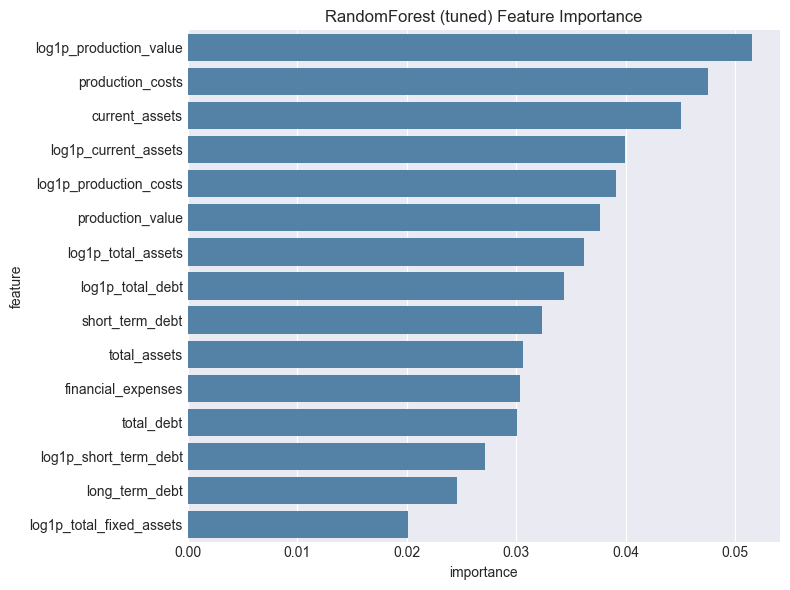

GradientBoosting (tuned) Feature Importance (top 15):
                 feature  importance
        production_value    0.070673
  log1p_production_value    0.067706
          legal_form_SPA    0.066583
     shareholders_equity    0.058844
        production_costs    0.053169
    log1p_current_assets    0.044294
          current_assets    0.043787
  log1p_production_costs    0.041867
unlimited_liability_form    0.038945
      log1p_total_assets    0.031018
    log1p_long_term_debt    0.029140
      financial_expenses    0.026536
            total_assets    0.024270
          asset_turnover    0.020662
        operating_income    0.019899


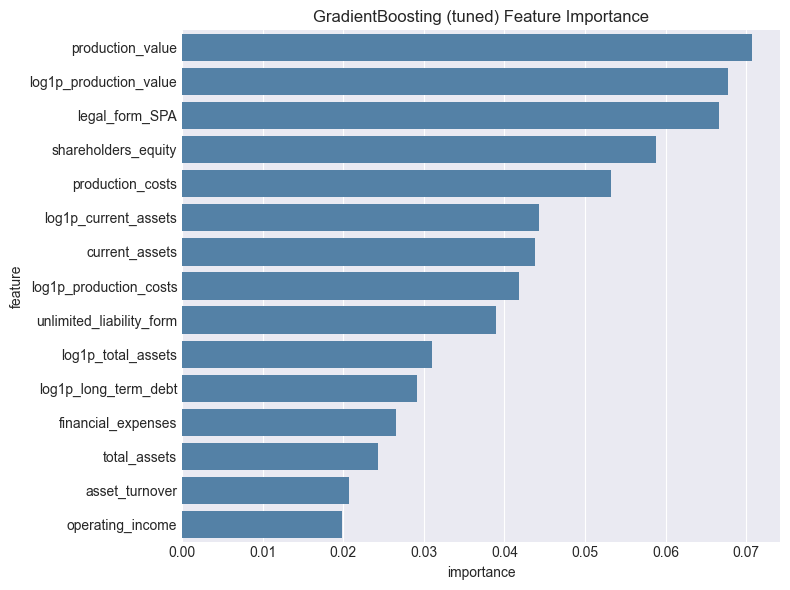

XGBoost (tuned) Feature Importance (top 15):
                    feature  importance
                 total_debt    0.163361
           production_costs    0.142601
           production_value    0.084333
               total_assets    0.077238
             current_assets    0.056063
             legal_form_SPA    0.039575
   unlimited_liability_form    0.033532
             long_term_debt    0.015618
            short_term_debt    0.011177
  is_extreme_revenue_change    0.010327
             corporate_form    0.009768
production_value_yoy_change    0.009619
 production_value_roll3_std    0.009477
             legal_form_SRL    0.009300
        shareholders_equity    0.008188


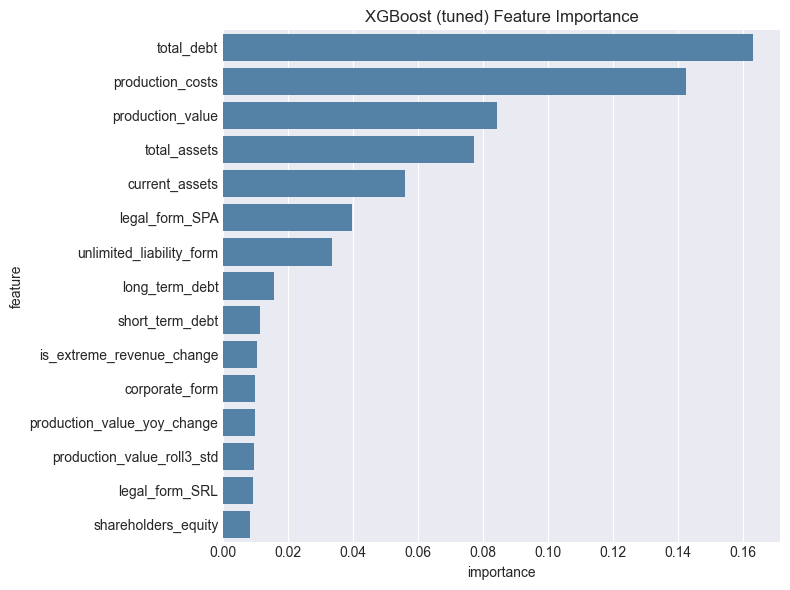

In [24]:
# Hyperparameter tuning (focused, leakage-safe) with target transform
# Tuning for RMSE + epsilon-MAPE (epsilon=0.02)
# NOTE: val/test have NaNs; use NaN-capable models only
# Tune only on TRAIN data using time-aware CV; evaluate on VAL after tuning.

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, GroupKFold, PredefinedSplit
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

# Choose scorer for tuning: 'mape' or 'mape_thr'
TUNING_SCORER = 'mape_thr'

# Use scaled features if available
if 'X_train_scaled' in globals():
    X_tr = X_train_scaled
    X_va = X_val_scaled
else:
    X_tr = X_train
    X_va = X_val

# Ensure no NaNs for estimators that don't accept missing values
# Use train medians for numeric columns; fill remaining with 0 as a final safety net
if isinstance(X_tr, pd.DataFrame):
    train_median = X_tr.median(numeric_only=True)
    X_tr_no_nan = X_tr.copy()
    X_va_no_nan = X_va.copy()
    X_tr_no_nan = X_tr_no_nan.fillna(train_median)
    X_va_no_nan = X_va_no_nan.fillna(train_median)
    X_tr_no_nan = X_tr_no_nan.fillna(0)
    X_va_no_nan = X_va_no_nan.fillna(0)
else:
    # numpy arrays
    X_tr_no_nan = np.nan_to_num(X_tr, nan=0.0)
    X_va_no_nan = np.nan_to_num(X_va, nan=0.0)

# Target transform selection
TARGET_TRANSFORM = globals().get('TARGET_TRANSFORM', 'signed_log')

def transform_target(y_train_clip, y_val_clip, method):
    if method == 'signed_log':
        return y_transform(y_train_clip), y_transform(y_val_clip), None
    if method == 'yeo_johnson':
        yj = PowerTransformer(method='yeo-johnson', standardize=True)
        return yj.fit_transform(y_train_clip.to_numpy().reshape(-1,1)).ravel(), yj.transform(y_val_clip.to_numpy().reshape(-1,1)).ravel(), yj
    return y_train_clip.to_numpy(), y_val_clip.to_numpy(), None

def inverse_target(preds_t, method, yj=None):
    if method == 'signed_log':
        return y_inverse(preds_t)
    if method == 'yeo_johnson' and yj is not None:
        return yj.inverse_transform(preds_t.reshape(-1,1)).ravel()
    return preds_t

# Winsorize target (train-only) to stabilize heavy tails
# Quantile transform features (train-only)
if isinstance(X_tr_no_nan, pd.DataFrame):
    qt = QuantileTransformer(n_quantiles=min(1000, len(X_tr_no_nan)), output_distribution='normal', random_state=RANDOM_STATE)
    X_tr_no_nan = qt.fit_transform(X_tr_no_nan)
    X_va_no_nan = qt.transform(X_va_no_nan)
else:
    qt = QuantileTransformer(n_quantiles=min(1000, X_tr_no_nan.shape[0]), output_distribution='normal', random_state=RANDOM_STATE)
    X_tr_no_nan = qt.fit_transform(X_tr_no_nan)
    X_va_no_nan = qt.transform(X_va_no_nan)

if 'winsorize_target' in globals():
    y_train_clip, y_val_clip, y_lo, y_hi = winsorize_target(y_train, y_val, lower=0.01, upper=0.99, hard_lo=REV_CHANGE_CAP_LO, hard_hi=REV_CHANGE_CAP_HI)
else:
    y_train_clip, y_val_clip = y_train.copy(), y_val.copy()
    y_lo, y_hi = None, None

# For tuning, use raw (winsorized) target to avoid CV leakage from global transform
Y_tr_t = y_train_clip
Y_va_t = y_val

# Tail-aware sample weights (train only)
sample_weights = 1.0 / (np.abs(y_train_clip) + 1.0)
# clip weights to avoid extremes
sample_weights = np.clip(sample_weights, 0.1, 10.0)


# Custom MAPE scorer (exclude zeros)
def mape_thresholded(y_true, y_pred, thr=NEAR_ZERO_THR):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = np.abs(y_true) >= thr
    if mask.sum() == 0:
        return np.nan, 0.0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    coverage = mask.mean() * 100
    return mape, coverage

def mape_safe(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape_scorer = make_scorer(mape_safe, greater_is_better=False)

# Thresholded MAPE scorer for near-zero stability
def mape_thr_only(y_true, y_pred):
    mape, _ = mape_thresholded(y_true, y_pred, thr=NEAR_ZERO_THR)
    return mape

mape_thr_scorer = make_scorer(mape_thr_only, greater_is_better=False)

# Select tuning scorer
scorer = mape_thr_scorer if TUNING_SCORER == 'mape_thr' else mape_scorer

def eps_mape(y_true, y_pred, eps=0.02):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100


# Time-aware CV split (train 2018 -> val 2019) to avoid leakage
if 'fiscal_year' in df_train.columns:
    split_mask = df_train['fiscal_year'].astype(int).apply(lambda y: 0 if y <= 2018 else (1 if y == 2019 else -1))
    # Use only 2018 (train) and 2019 (val) for CV; drop other years
    cv = PredefinedSplit(test_fold=split_mask)
    # Filter training data to the CV years for tuning
    cv_mask = split_mask >= 0
    X_tr_no_nan = X_tr_no_nan[cv_mask]
    Y_tr_t = Y_tr_t[cv_mask]
    if 'sample_weights' in locals():
        sample_weights = sample_weights[cv_mask]
else:
    cv = TimeSeriesSplit(n_splits=3)


# Random Forest tuning
rf_param_dist = {
    'n_estimators': [300, 600, 900],
    'max_depth': [None, 12, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt', 'log2']
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    rf_param_dist,
    n_iter=15,
    scoring=scorer,
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_search.fit(X_tr_no_nan, Y_tr_t, sample_weight=sample_weights, groups=groups if "groups" in locals() else None)
rf_best = rf_search.best_estimator_

# Optional: XGBoost tuning (if available)
try:
    from xgboost import XGBRegressor
    xgb_param_dist = {
        'n_estimators': [400, 800, 1200],
        'learning_rate': [0.02, 0.05, 0.08],
        'max_depth': [2, 3, 4],
        'min_child_weight': [5, 10, 20],
        'subsample': [0.7, 0.85, 1.0],
        'colsample_bytree': [0.7, 0.85, 1.0],
        'reg_alpha': [0, 0.1, 1.0],
        'reg_lambda': [1.0, 5.0, 10.0]
    }
    xgb_search = RandomizedSearchCV(
        XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1),
        xgb_param_dist,
        n_iter=12,
        scoring=scorer,
        cv=cv,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    xgb_search.fit(X_tr_no_nan, Y_tr_t, sample_weight=sample_weights, groups=groups if "groups" in locals() else None)
    xgb_best = xgb_search.best_estimator_
except Exception as e:
    xgb_best = None
    print(f"XGBoost tuning skipped: {e}")

# Gradient Boosting tuning
gb_param_dist = {
    'n_estimators': [300, 600, 900],
    'learning_rate': [0.02, 0.05, 0.08],
    'max_depth': [2, 3, 4],
    'subsample': [0.7, 0.85, 1.0],
    'loss': ['absolute_error', 'huber']
}

gb_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=RANDOM_STATE),
    gb_param_dist,
    n_iter=12,
    scoring=scorer,
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

gb_search.fit(X_tr_no_nan, Y_tr_t, sample_weight=sample_weights, groups=groups if "groups" in locals() else None)
gb_best = gb_search.best_estimator_


# HistGradientBoosting tuning (robust + strong on skewed targets)
hgb_param_dist = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.02, 0.05, 0.08],
    'max_iter': [300, 600, 900],
    'min_samples_leaf': [20, 50, 100],
    'l2_regularization': [0.1, 1.0, 5.0],
    'max_bins': [64, 128, 255],
    'loss': ['absolute_error', 'squared_error']
}

hgb_search = RandomizedSearchCV(
    HistGradientBoostingRegressor(random_state=RANDOM_STATE),
    hgb_param_dist,
    n_iter=12,
    scoring=scorer,
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

hgb_search.fit(X_tr_no_nan, Y_tr_t, sample_weight=sample_weights, groups=groups if 'groups' in locals() else None)
hgb_best = hgb_search.best_estimator_
# Metrics helper

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.where(denom == 0, 0, np.abs(y_true - y_pred) / denom)) * 100


def directional_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.sign(y_true[mask]) == np.sign(y_pred[mask])) * 100




def eval_metrics(model, X, y_true, transformed=True, calibrate=False):
    preds_t = model.predict(X)
    preds = inverse_target(preds_t, TARGET_TRANSFORM, yj) if transformed else preds_t

    # optional linear calibration on predictions
    if calibrate:
        from sklearn.linear_model import LinearRegression
        lr = LinearRegression()
        lr.fit(preds.reshape(-1, 1), y_true)
        preds = lr.predict(preds.reshape(-1, 1))

    rmse = mean_squared_error(y_true, preds, squared=False)
    mae = mean_absolute_error(y_true, preds)
    mdae = median_absolute_error(y_true, preds)
    mape = mape_safe(y_true, preds)
    mape_thr, mape_cov = mape_thresholded(y_true, preds, thr=NEAR_ZERO_THR)
    r2 = r2_score(y_true, preds)

    # tail metrics
    tail_mask = y_true.abs() > 50
    if tail_mask.any():
        tail_rmse = mean_squared_error(y_true[tail_mask], preds[tail_mask], squared=False)
        tail_mae = mean_absolute_error(y_true[tail_mask], preds[tail_mask])
    else:
        tail_rmse, tail_mae = np.nan, np.nan

    return rmse, mae, mdae, mape, mape_thr, mape_cov, r2, smape(y_true, preds), directional_accuracy(y_true, preds), tail_rmse, tail_mae





results = []

if 'hgb_best' in locals():
    rmse, mae, mdae, mape, mape_thr, mape_cov, r2, sm, da, trmse, tmae = eval_metrics(hgb_best, X_va_no_nan, y_val, transformed=False)
    results.append({'Model': 'HistGradientBoosting (tuned)', 'RMSE': rmse, 'MAE': mae, 'MdAE': mdae, 'MAPE': mape, 'MAPE_thr': mape_thr, 'MAPE_cov(%)': mape_cov, 'SMAPE': sm, 'R2': r2, 'DirectionalAcc(%)': da, 'Tail_RMSE': trmse, 'Tail_MAE': tmae})

rmse, mae, mdae, mape, mape_thr, mape_cov, r2, sm, da, trmse, tmae = eval_metrics(rf_best, X_va_no_nan, y_val, transformed=False)
results.append({'Model': 'RandomForest (tuned)', 'RMSE': rmse, 'MAE': mae, 'MdAE': mdae, 'MAPE': mape, 'MAPE_thr': mape_thr, 'MAPE_cov(%)': mape_cov, 'SMAPE': sm, 'R2': r2, 'DirectionalAcc(%)': da, 'Tail_RMSE': trmse, 'Tail_MAE': tmae})

rmse, mae, mdae, mape, mape_thr, mape_cov, r2, sm, da, trmse, tmae = eval_metrics(gb_best, X_va_no_nan, y_val, transformed=False)
results.append({'Model': 'GradientBoosting (tuned)', 'RMSE': rmse, 'MAE': mae, 'MdAE': mdae, 'MAPE': mape, 'MAPE_thr': mape_thr, 'MAPE_cov(%)': mape_cov, 'SMAPE': sm, 'R2': r2, 'DirectionalAcc(%)': da, 'Tail_RMSE': trmse, 'Tail_MAE': tmae})

if xgb_best is not None:
    rmse, mae, mdae, mape, mape_thr, mape_cov, r2, sm, da, trmse, tmae = eval_metrics(xgb_best, X_va_no_nan, y_val, transformed=False)
    results.append({'Model': 'XGBoost (tuned)', 'RMSE': rmse, 'MAE': mae, 'MdAE': mdae, 'MAPE': mape, 'MAPE_thr': mape_thr, 'MAPE_cov(%)': mape_cov, 'SMAPE': sm, 'R2': r2, 'DirectionalAcc(%)': da, 'Tail_RMSE': trmse, 'Tail_MAE': tmae})

results_df = pd.DataFrame(results).sort_values('RMSE')
print("Tuned models evaluated on validation set (original scale, tail metrics included):")
display(results_df)

print("Hyperparameter tuning complete!")






# Feature importance (tuned models)
try:
    if isinstance(X_tr, pd.DataFrame):
        feature_names = X_tr.columns.tolist()
    else:
        feature_names = X_train.columns.tolist() if 'X_train' in globals() else [f'f{i}' for i in range(X_tr.shape[1])]

    def print_and_plot_importance(model, title, top_n=15):
        if not hasattr(model, 'feature_importances_'):
            print(f"{title}: no feature_importances_ attribute")
            return
        importances = model.feature_importances_
        fi = pd.DataFrame({'feature': feature_names, 'importance': importances})
        fi = fi.sort_values('importance', ascending=False).head(top_n)
        print(f"{title} (top {top_n}):")
        print(fi.to_string(index=False))

        plt.figure(figsize=(8, 6))
        sns.barplot(data=fi, x='importance', y='feature', color='steelblue')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    print_and_plot_importance(rf_best, 'RandomForest (tuned) Feature Importance')
    print_and_plot_importance(gb_best, 'GradientBoosting (tuned) Feature Importance')
    if xgb_best is not None:
        print_and_plot_importance(xgb_best, 'XGBoost (tuned) Feature Importance')
except Exception as e:
    print(f"Feature importance skipped: {e}")


## 6. Model Evaluation

Compare models and select the best one.

In [25]:
# TODO: Create model comparison table
# Compare all models on validation set using appropriate metrics

# For Challenge 1: F1-Score, AUC-ROC, Precision, Recall
# For Challenge 2: Weighted F1, Macro F1, Accuracy, Confusion Matrix
# For Challenge 3: RMSE, MAE, MAPE, R², Directional Accuracy

# Example comparison:
# models_comparison = pd.DataFrame({
#     'Model': ['Baseline', 'Random Forest', 'XGBoost'],
#     'F1-Score': [...],
#     'AUC-ROC': [...],
#     'Precision': [...],
#     'Recall': [...]
# })
# print(models_comparison)

In [26]:
# TODO: Confusion Matrix (for classification)
# from sklearn.metrics import ConfusionMatrixDisplay

# ConfusionMatrixDisplay.from_estimator(best_model, X_val_scaled, y_val)
# plt.title('Confusion Matrix - Best Model')
# plt.show()

In [27]:
# TODO: ROC Curve (for binary classification)
# from sklearn.metrics import RocCurveDisplay

# RocCurveDisplay.from_estimator(best_model, X_val_scaled, y_val)
# plt.title('ROC Curve - Best Model')
# plt.show()

**Model Selection:**

TODO: Justify your final model choice
- 
- 

## 7. Interpretation and Business Insights

Explain the model and extract business value.

In [28]:
# TODO: Feature Importance
# For tree-based models, use built-in feature importance
# For other models, consider SHAP values

# Example:
# feature_importance = pd.DataFrame({
#     'feature': feature_cols,
#     'importance': best_model.feature_importances_
# }).sort_values('importance', ascending=False)

# plt.figure(figsize=(10, 6))
# plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
# plt.xlabel('Importance')
# plt.title('Top 15 Most Important Features')
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

In [29]:
# TODO: Error Analysis
# - Which cases does the model misclassify/mispredicts?
# - Are there patterns in the errors?
# - How do errors vary by sector, size, region, etc.?

# Example:
# errors_df = df_val.copy()
# errors_df['prediction'] = y_pred
# errors_df['error'] = (errors_df['prediction'] != errors_df[target_col])

# print("Error rate by sector:")
# print(errors_df.groupby('ateco_sector')['error'].mean().sort_values(ascending=False))

**Business Insights:**

TODO: Translate technical findings into business language

**Key Risk Factors** (for bankruptcy/health challenges):
1. 
2. 
3. 

**Revenue Drivers** (for forecasting challenge):
1. 
2. 
3. 

**Actionable Recommendations:**
- 
- 
- 

## 8. Conclusions and Future Work

Summarize findings and discuss limitations.

**Summary:**

TODO: Summarize your work
- 
- 

**Performance vs Targets:**

TODO: Compare your results to challenge targets
- My F1-Score: [X.XX] vs Target: [0.55-0.70]
- ...

**Model Limitations:**

TODO: Discuss limitations honestly
1. 
2. 
3. 

**Future Improvements:**

TODO: What would you do with more time?
1. 
2. 
3. 

**Lessons Learned:**

TODO: Reflect on the experience
- 
- 

---

## Final Checklist

Before submitting, verify:

- [ ] All code cells execute without errors
- [ ] Markdown cells explain each step clearly
- [ ] Visualizations are clear and labeled
- [ ] Feature importance is analyzed
- [ ] Error analysis is performed
- [ ] Business insights are provided
- [ ] Model limitations are discussed
- [ ] Code is well-commented
- [ ] Results meet or exceed minimum performance targets
- [ ] No data leakage (temporal split, proper scaling, etc.)
- [ ] Citations for any external code/resources

**Good luck with your challenge!** 🚀